# <span style='font-family:"Times New Roman"'> <span styel=''>**GLIOMA ANALYSIS**

*Emile Cohen*
    
*June 2020*

**Goal**: In this notebook, we want to understand what makes Glioma an outlier for the patterns we saw, and what are the major subcohorts that drive the outlying signal.

---

In [15]:
%run -i '../../../../../utils/setup_environment.ipy'

import warnings
warnings.filterwarnings('ignore')
from scipy.stats import fisher_exact, ranksums, chi2, norm
from statsmodels.sandbox.stats.multicomp import multipletests
import matplotlib.gridspec as gridspec
import pickle

data_path = '../../../../../data/'
data_wgd = data_path + 'impact-facets-tp53/processed/wgd/'
data_no_wgd = data_path + 'impact-facets-tp53/processed/no_wgd/'

Setup environment... done!


<span style="color:green">✅ Working on **mskimpact_env** conda environment.</span>

## Interesting functions

In [19]:
from functools import reduce

def get_hotspots(df: pd.DataFrame, Sample_Type: str, group: list = None, group_type:str = None):
    data = df[df['Sample_Type'] == Sample_Type]
    
    if group and group_type:
        data = data[data[group_type].isin(group)]

    data_1 = get_groupby(data,'tp53_spot_1', 'count'); data_2 = get_groupby(data,'tp53_spot_2', 'count'); data_3 = get_groupby(data,'tp53_spot_3', 'count') ; data_4 = get_groupby(data,'tp53_spot_4', 'count') ; data_5 = get_groupby(data,'tp53_spot_5', 'count') 
    series_data = [data_1,data_2,data_3,data_4,data_5]

    df_merged = reduce(lambda  left,right: pd.merge(left,right,left_index=True, right_index=True,
                                                how='outer'), series_data).fillna(0)

    df_merged.columns = ['count_1', 'count_2', 'count_3', 'count_4', 'count_5']
    df_merged['total'] = df_merged.sum(axis=1)
    df_merged = df_merged.sort_values(by='total', ascending=False)

    df_merged = df_merged.drop('nan')
    
    return df_merged

def get_hotspot_frac(df: pd.DataFrame, group_type:str = None, group: list = None, nb = 10):
    if group_type and group:
        df = df[df[group_type].isin(group)]
    result = [['spot', '#', 'frac']]
    for spot in get_groupby(df, 'tp53_spot_1', 'count').sort_values(by='count', ascending=False).head(nb).index.tolist():
        result.append([spot,df[df['tp53_spot_1'] == spot].frac_genome_altered.shape[0], df[df['tp53_spot_1'] == spot].frac_genome_altered.median()])

    return pd.DataFrame(result)



def boxplot_sampletype(df: pd.DataFrame, group:str, palette, order, metrics: str, figsize= (10,3), title: str = '', title_font: int=12, xlim=[0,1]):
    fig=plt.figure(figsize=figsize)
    ax = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1)

    sns.boxplot(y=metrics, x=group,data=df,ax=ax, dodge=False,order=order, palette=palette).set_title(title, weight='bold', fontsize=title_font)
    
    groupby_ = get_groupby(df,group, 'count')
    groupby_ = groupby_.T
    for mut in mutation_list:
        if mut not in groupby_.columns:
            groupby_[mut] = 0
    groupby_ = groupby_.T
    
    labels = []
    for element in order:
        labels.append(element + '\n('+ str(groupby_.loc[element].values[0])+')')
    
    
    
    ax.set_xticklabels(labels)
    style(ax)
    ax.set_ylim(xlim)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    return fig, ax
# Let's give a look at medians and statistics

def get_statistics(df: pd.DataFrame, group:str, metrics: str, group_list: list):
    group_1 = df[df[group] == group_list[0]][metrics]
    group_2 = df[df[group] == group_list[1]][metrics]

    median_1 = group_1.median()
    median_2 = group_2.median()

    statistic, p_value = ranksums(group_1.dropna().values,group_2.dropna().values)
    
    results = [['', 'size', metrics],
               [group_list[0], group_1.shape[0], median_1],
               [group_list[1], group_2.shape[0], median_2],
               ['', 'Statistics', 'p-value'],
               ['', statistic, p_value]]


    return pd.DataFrame(results)

## Master Definition and Filtering

In [8]:
cancer='Glioma'

In [9]:
master_no_wgd = non_wgd_load_and_cut(data_path + 'impact-facets-tp53/processed/no_wgd/master_no_wgd.pkl')
master_wgd = pd.read_pickle(data_path + 'impact-facets-tp53/processed/wgd/master_wgd.pkl')

master_no_wgd_cancer = master_no_wgd[master_no_wgd['Cancer_Type'] == cancer]
master_wgd_cancer = master_wgd[master_wgd['Cancer_Type'] == cancer]

# What makes Glioma an Outlier?

## WGD Proportion

Glioma is the cancer with the lowest WGD proportion, around 5%:
<img src="wgd_proportion.png" width=700 length=700>

## Cancer Panel - Non WGD Cohort

<img src="subgroup_proportion.png">

Glioma is highly enriched in Primary Samples, in *>1muts* subgroup and in composite mutation samples in general

## Genome Instability

<img src="gi_pancancer_frac_no_wgd.png">

Glioma is one of the three cancers that shows an outlying signal in Genome Instability Pattern: while almost all cancers have a correlation between tp53 bi allelic state, Glioma, Pancreatic Cancer an d Melanoma do not show this GI difference.

# WGD Part

## Subgroup Proportion
We have already seen that the WGD proportion of Glioma was really low. Here we see that the WGD cohort size is very small in comparison with the Non-WGD Cohort size for Glioma.

<img src="pre_prop.png" width=1000 length=600>
<img src="pre_legend.png" width=200 length=200>

<img src="mut_loh_prop.png" width=1000 length=600>
<img src="mut_loh_legend.png" width=200 length=200>

## Very High Genome Instability

In WGD cohort, Genome Instability median is above 70% for all cancer types.

<img src="pancancer_gi_wgd.png" width=1000 length=600>

# Non WGD Part - Cancer Investigation
In this section, our goal is to find subcohorts that lead the signals observed. Here are the different subcohort we will create:
* Hotspot Analysis: splitting on 273 / 248 / 175 / Missense / Truncated / In Frame
* CCF Analysis
* SNV/INDEL Analysis

## Hotspot Analysis
In this section, we cut our cohort to only keep samples with exactly one TP53 mutation, for simplicity.

<img src="mut_hotspot.png" width=500 length=500>

In [10]:
master_hotspot = master_no_wgd_cancer[master_no_wgd_cancer['tp53_count'] == 1]

In [13]:
get_hotspot_frac(df=master_hotspot,
                group_type=None,
                group=None)

,0,1,2
0,spot,#,frac
1,273,29,0.171
2,248,23,0.17
3,nan,10,0.34
4,175,9,0.203
5,193,8,0.1855
6,282,8,0.211
7,245,7,0.256
8,238,7,0.214
9,342,6,0.334


### Entire Cohort

,count
tp53_vc_group_1,
missense,118
truncated,49
273,29
248,23
hotspot,19
in_frame,12
175,9


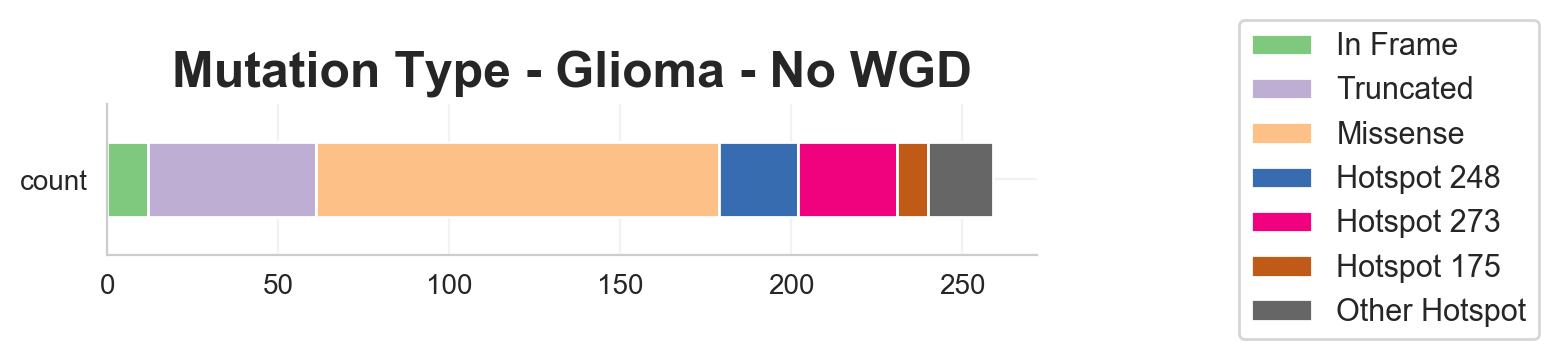

In [20]:
h = get_groupby(master_hotspot,'tp53_vc_group_1', 'count').sort_values(by='count', ascending=False)
display(h)

h = h.T
h = h[mutation_list]
fig = plt.figure(figsize=(6,1))
ax = plt.subplot()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

h_plot = h.plot(kind = 'barh', stacked=True, yticks=[], ax=ax, colormap="Accent")
ax.legend(['In Frame', 'Truncated', 'Missense', 'Hotspot 248','Hotspot 273','Hotspot 175', 'Other Hotspot'],loc='center left', bbox_to_anchor=(1.2, 0.5), fontsize=11)
ax.set_title('Mutation Type - {} - No WGD'.format(cancer), weight='bold', fontsize=18)

plt.show()

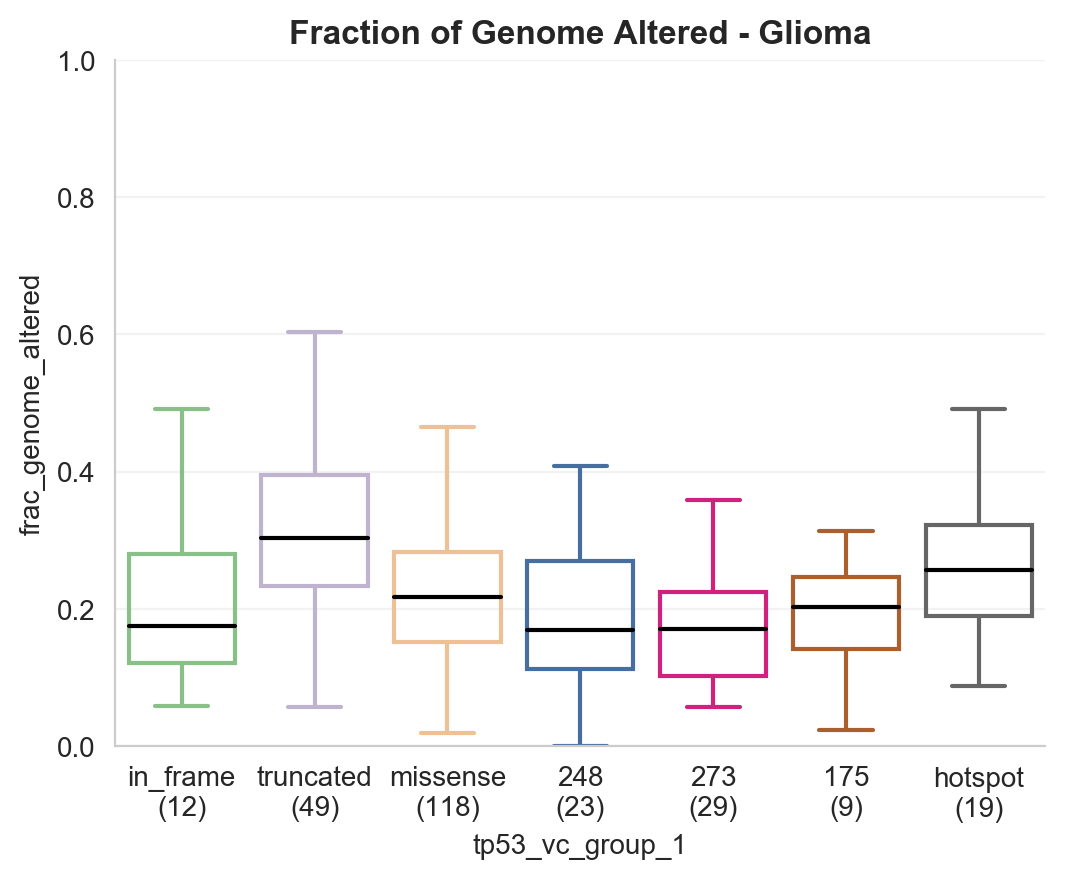

In [21]:
fig, ax = boxplot_sampletype(df=master_hotspot,
                  group='tp53_vc_group_1',
                  palette=mutation_palette,
                  order=mutation_list,
                  metrics='frac_genome_altered',
                  figsize=(6,10),
                  title='Fraction of Genome Altered - {}'.format(cancer),
                  xlim=[0,1])
plt.show()

* **Once more, it seems that 273 hotspot leads to lower GI**
* **In Glioma, Truncated mutations seem to be more unstable than Missense**

### TP53 Residual Subgroups

In [22]:
print('Number of Bi Allelic samples (with 1 mut): ' + str(master_hotspot[master_hotspot['tp53_res_group'] == 'no_tp53_res'].shape[0]))
print('')
print('Number of  TP53 Residual samples (with 1 mut): ' + str(master_hotspot[master_hotspot['tp53_res_group'] == 'tp53_res'].shape[0]))



Number of Bi Allelic samples (with 1 mut): 182

Number of  TP53 Residual samples (with 1 mut): 63


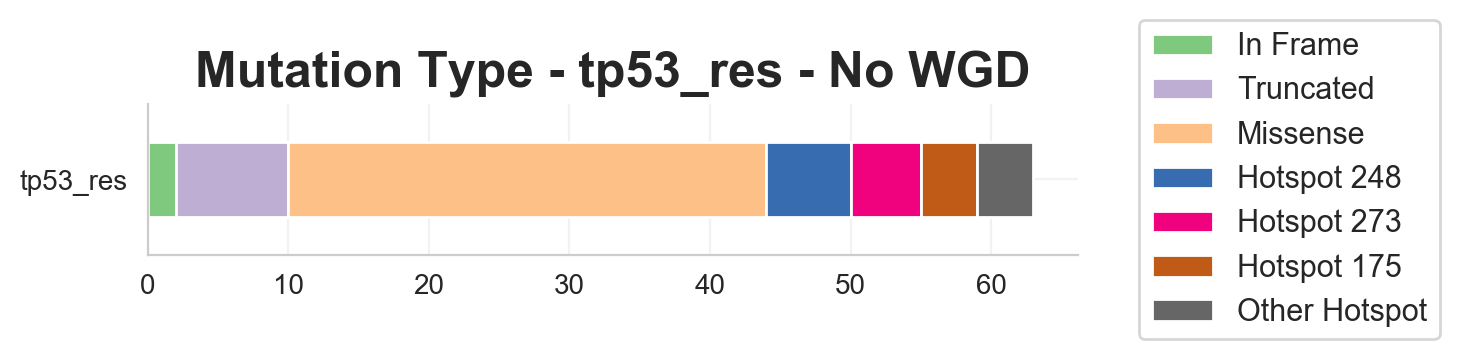

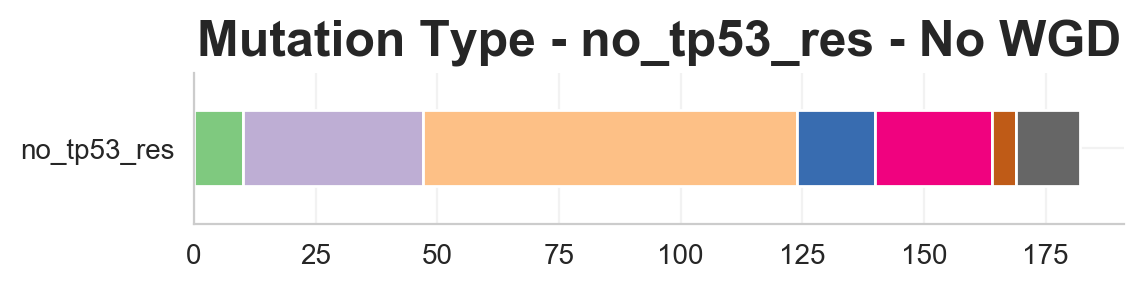

,tp53_res
tp53_vc_group_1,
missense,34
truncated,8
248,6
273,5
175,4
hotspot,4
in_frame,2
,no_tp53_res
tp53_vc_group_1,


In [23]:
total_df = []
for group in ['tp53_res', 'no_tp53_res']:
    h = get_groupby(master_hotspot[master_hotspot['tp53_res_group'] == group], 'tp53_vc_group_1', group).sort_values(by=group, ascending=False)
    total_df.append(h)
    
    h=h.T
    
    for mut in mutation_list:
        if mut not in h.columns:
            h[mut] = 0

    h = h[mutation_list]
    fig = plt.figure(figsize=(6,1))
    ax = plt.subplot()

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    h_plot = h.plot(kind = 'barh', stacked=True, yticks=[], ax=ax, colormap="Accent")
    if group == 'tp53_res':
        ax.legend(['In Frame', 'Truncated', 'Missense', 'Hotspot 248','Hotspot 273','Hotspot 175', 'Other Hotspot'],loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=11)
    else: ax.get_legend().remove()
    ax.set_title('Mutation Type - {} - No WGD'.format(group), weight='bold', fontsize=18)

    plt.show()

display_side_by_side(total_df[0],total_df[1])

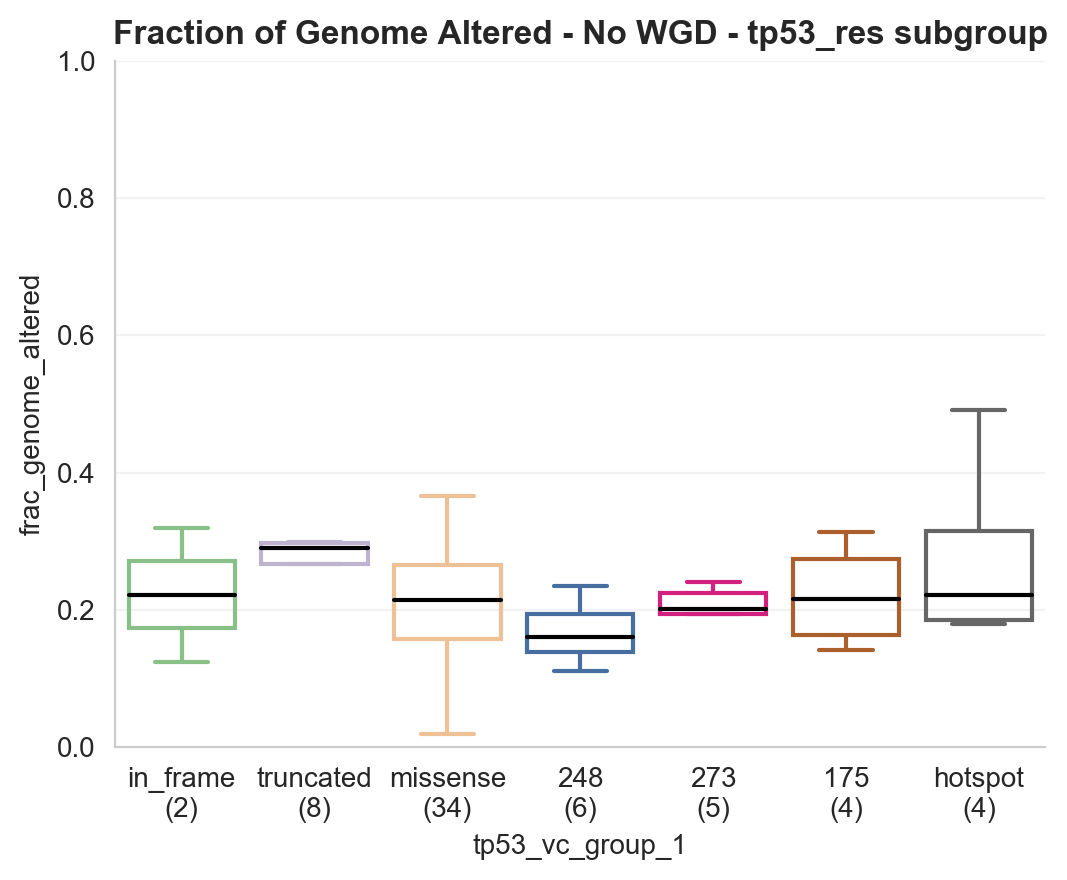

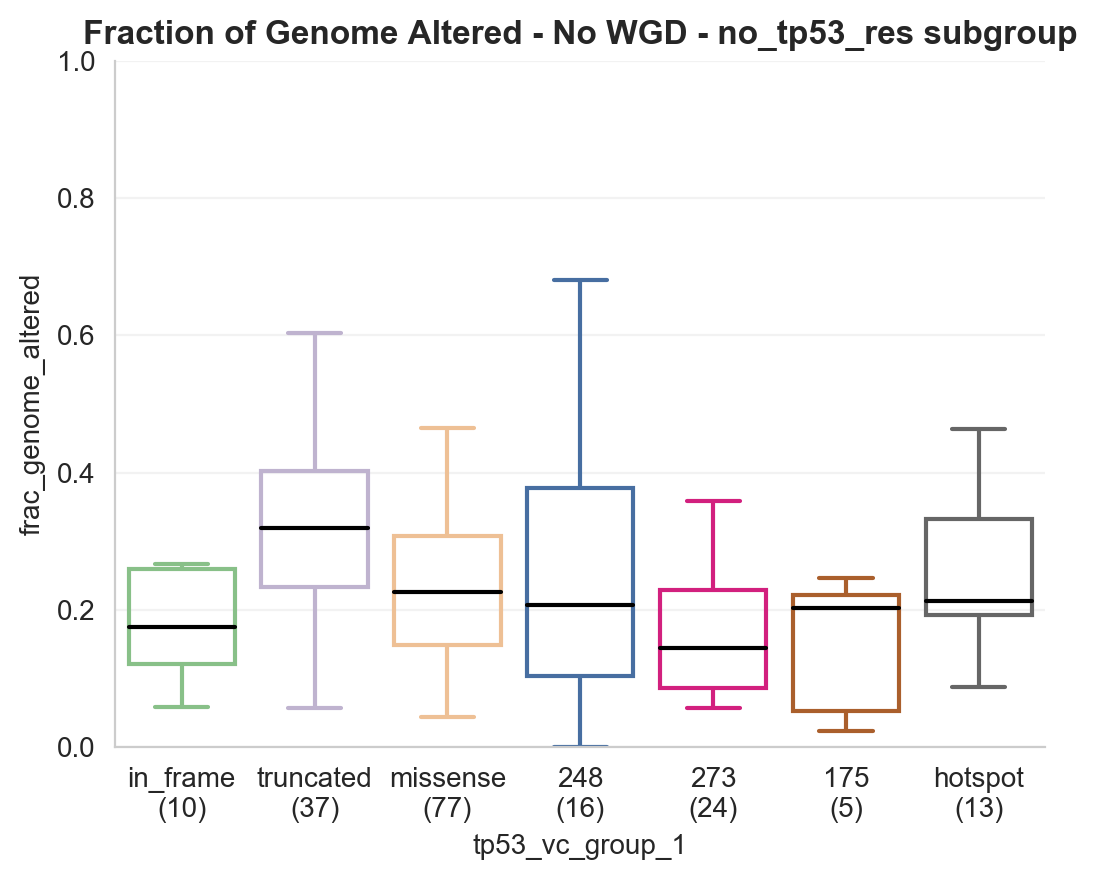

In [24]:
for group in ['tp53_res', 'no_tp53_res']:
    master_wt = master_hotspot[master_hotspot['tp53_res_group'] == group]

    fig, ax = boxplot_sampletype(df=master_wt,
                      group='tp53_vc_group_1',
                      palette=mutation_palette,
                      order=mutation_list,
                      metrics='frac_genome_altered',
                      figsize=(6,10),
                      title='Fraction of Genome Altered - No WGD - {} subgroup'.format(group),
                      xlim=[0,1])
    plt.show()

## SNV / INDEL Analysis
In this section we compare SNV and INDEL mutations. As in the previous section, we cut the cohort to keep only samples with exactly 1 tp53 mutation.

###  # of Drivers / SNV Drivers / INDEL Drivers 

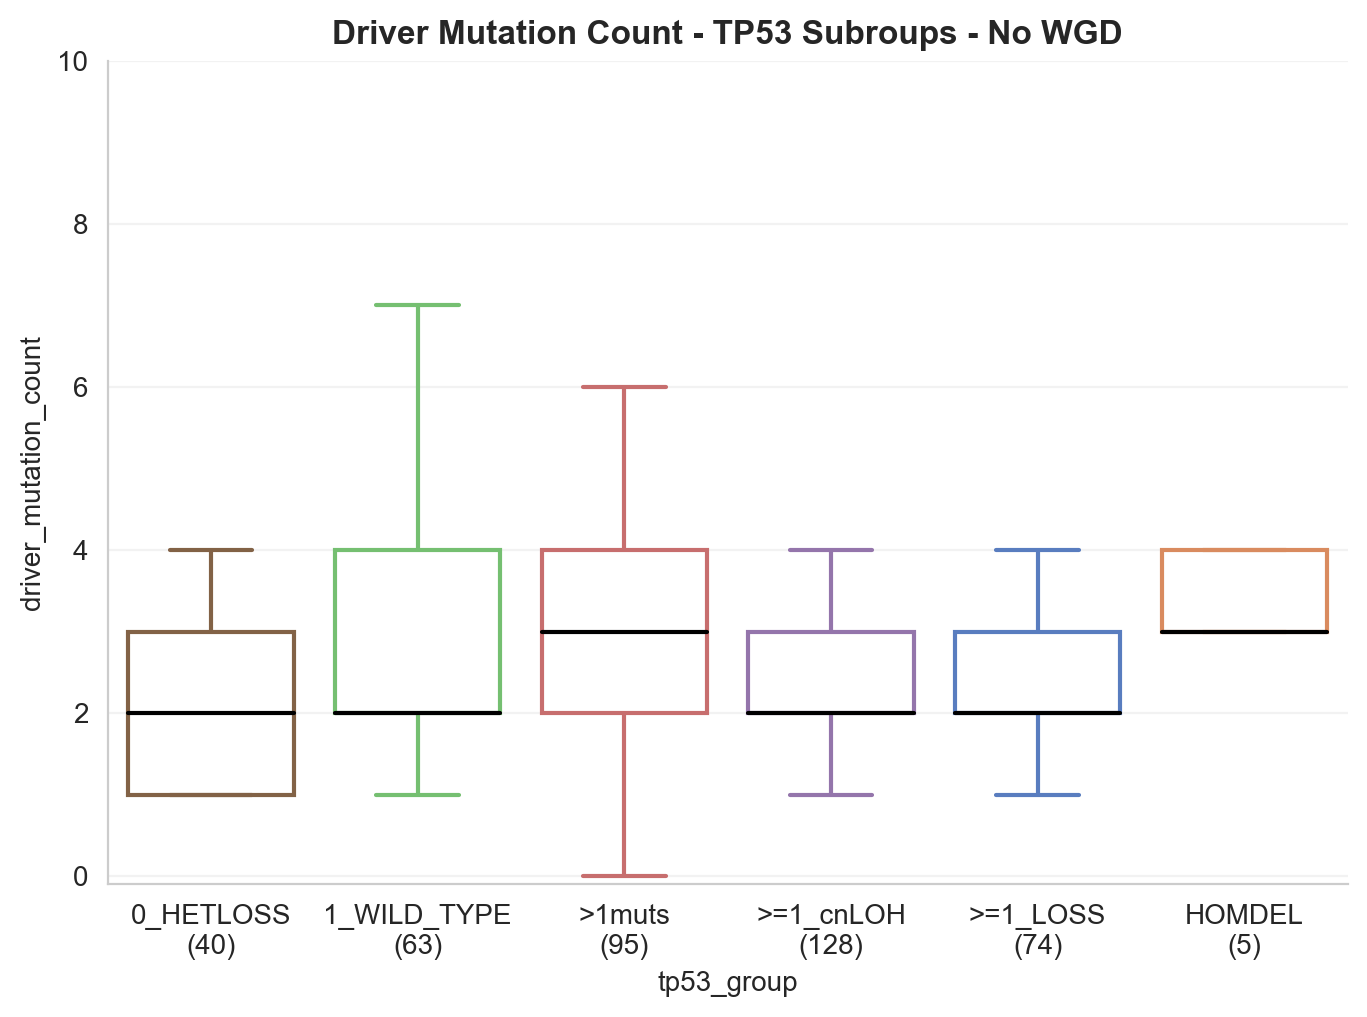

,0,1,2
0,,size,driver_mutation_count
1,1_WILD_TYPE,63,2
2,0_HETLOSS,40,2
3,,Statistics,p-value
4,,1.69166,0.0907104
,0,1,2
0,,size,driver_mutation_count
1,1_WILD_TYPE,63,2
2,>=1_LOSS,74,2
3,,Statistics,p-value


In [25]:
fig, ax = boxplot_sampletype(df=master_no_wgd_cancer,
                  group='tp53_group',
                  palette=palette,
                  order=group_list,
                  metrics='driver_mutation_count',
                  figsize=(8,12),
                  title='Driver Mutation Count - TP53 Subroups - No WGD',
                  xlim=[-0.1,10])
plt.show()

display_side_by_side(get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='driver_mutation_count', 
               group_list=['1_WILD_TYPE', '0_HETLOSS']),
       
       get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='driver_mutation_count', 
               group_list=['1_WILD_TYPE', '>=1_LOSS']),
        
       get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='driver_mutation_count', 
               group_list=['>1muts', '>=1_LOSS']))

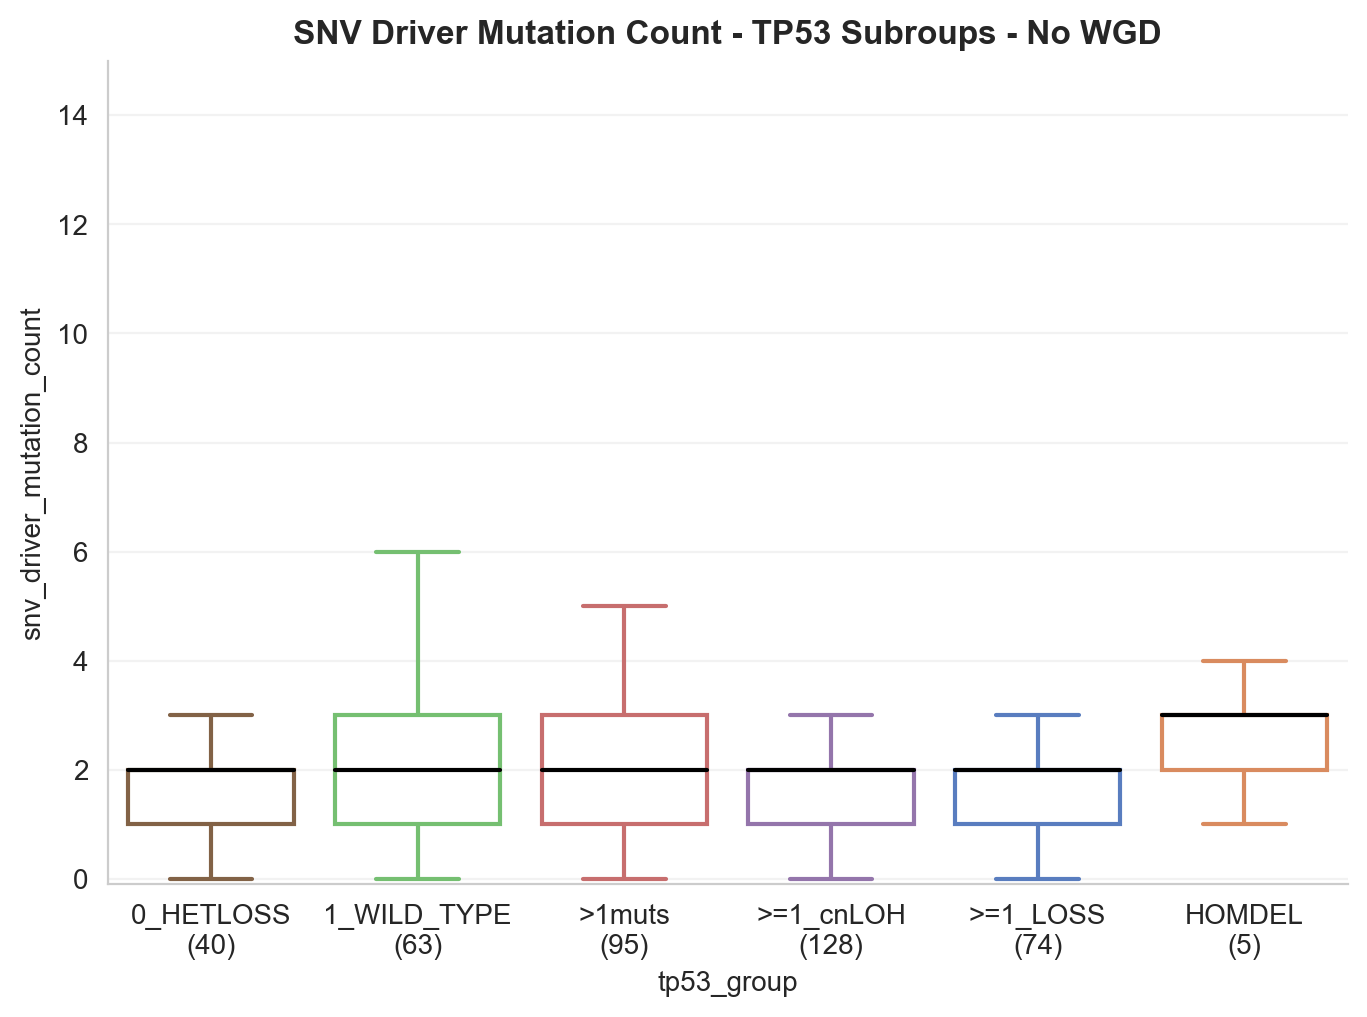

,0,1,2
0,,size,snv_driver_mutation_count
1,1_WILD_TYPE,63,2
2,0_HETLOSS,40,2
3,,Statistics,p-value
4,,2.13826,0.0324955
,0,1,2
0,,size,snv_driver_mutation_count
1,1_WILD_TYPE,63,2
2,>=1_LOSS,74,2
3,,Statistics,p-value


In [26]:
fig, ax = boxplot_sampletype(df=master_no_wgd_cancer,
                  group='tp53_group',
                  palette=palette,
                  order=group_list,
                  metrics='snv_driver_mutation_count',
                  figsize=(8,12),
                  title='SNV Driver Mutation Count - TP53 Subroups - No WGD',
                  xlim=[-0.1,15])
plt.show()

display_side_by_side(get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='snv_driver_mutation_count', 
               group_list=['1_WILD_TYPE', '0_HETLOSS']),
       
       get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='snv_driver_mutation_count', 
               group_list=['1_WILD_TYPE', '>=1_LOSS']),
        
       get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='snv_driver_mutation_count', 
               group_list=['>1muts', '>=1_LOSS']))

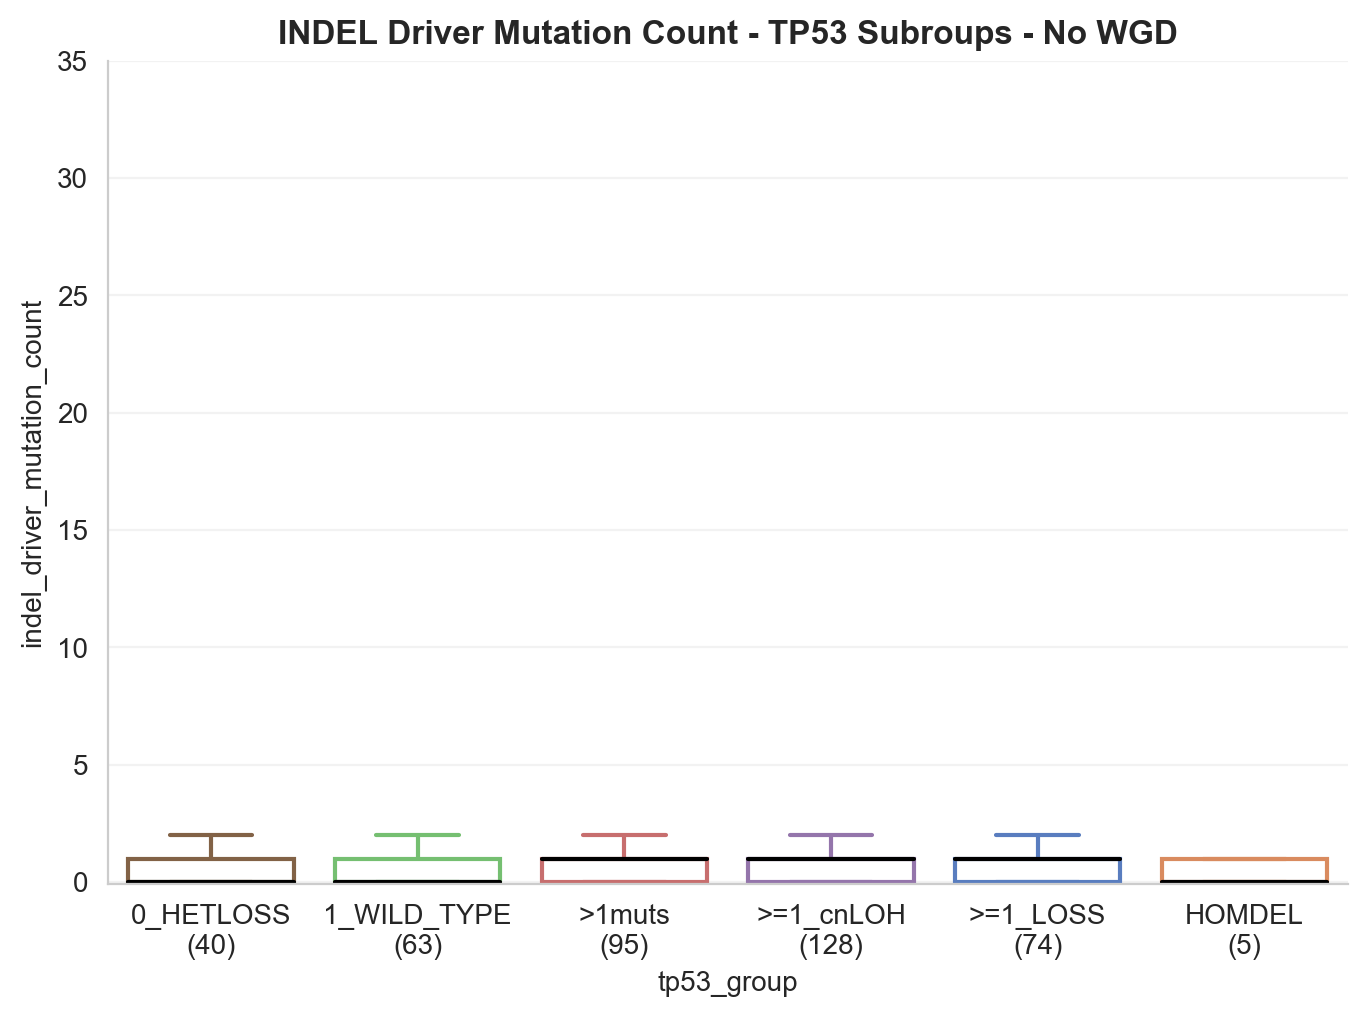

,0,1,2
0,,size,indel_driver_mutation_count
1,1_WILD_TYPE,63,0
2,0_HETLOSS,40,0
3,,Statistics,p-value
4,,-0.17255,0.863006
,0,1,2
0,,size,indel_driver_mutation_count
1,1_WILD_TYPE,63,0
2,>=1_LOSS,74,1
3,,Statistics,p-value


In [27]:
fig, ax = boxplot_sampletype(df=master_no_wgd_cancer,
                  group='tp53_group',
                  palette=palette,
                  order=group_list,
                  metrics='indel_driver_mutation_count',
                  figsize=(8,12),
                  title='INDEL Driver Mutation Count - TP53 Subroups - No WGD',
                  xlim=[-0.1,35])
plt.show()

display_side_by_side(get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='indel_driver_mutation_count', 
               group_list=['1_WILD_TYPE', '0_HETLOSS']),
       
       get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='indel_driver_mutation_count', 
               group_list=['1_WILD_TYPE', '>=1_LOSS']),
        
       get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='indel_driver_mutation_count', 
               group_list=['>1muts', '>=1_LOSS']))

Here, one major information:
* In Glioma, there are very few numbers of Co-Drivers, INDEL Co-Drivers nor SNV Co-Drivers.
    * Maybe TP53 mutations in Glioma are very pervasvie and do not need more drivers to expand

### Genome Instability 
The idea here is to see if we have differences in Fraction of Genome Altered if we cut our Cancer cohort on the number of drivers per sample. 

Do we have more instability with more INDEL Driver Mutations within the same subgroup?

#### 1_WILD_TYPE Subgroup

In [28]:
master_no_wgd_cancer_wt = master_no_wgd_cancer[master_no_wgd_cancer['tp53_group'] == '1_WILD_TYPE']

thr=1

def get_driver_groups(x):
    if x.indel_driver_mutation_count > thr:
        return 'High Co-Driver Count'
    if x.indel_driver_mutation_count <= thr:
        return 'Low Co-Driver Count'
    

master_no_wgd_cancer_wt['co_driver_group'] = master_no_wgd_cancer_wt.apply(get_driver_groups, axis=1)

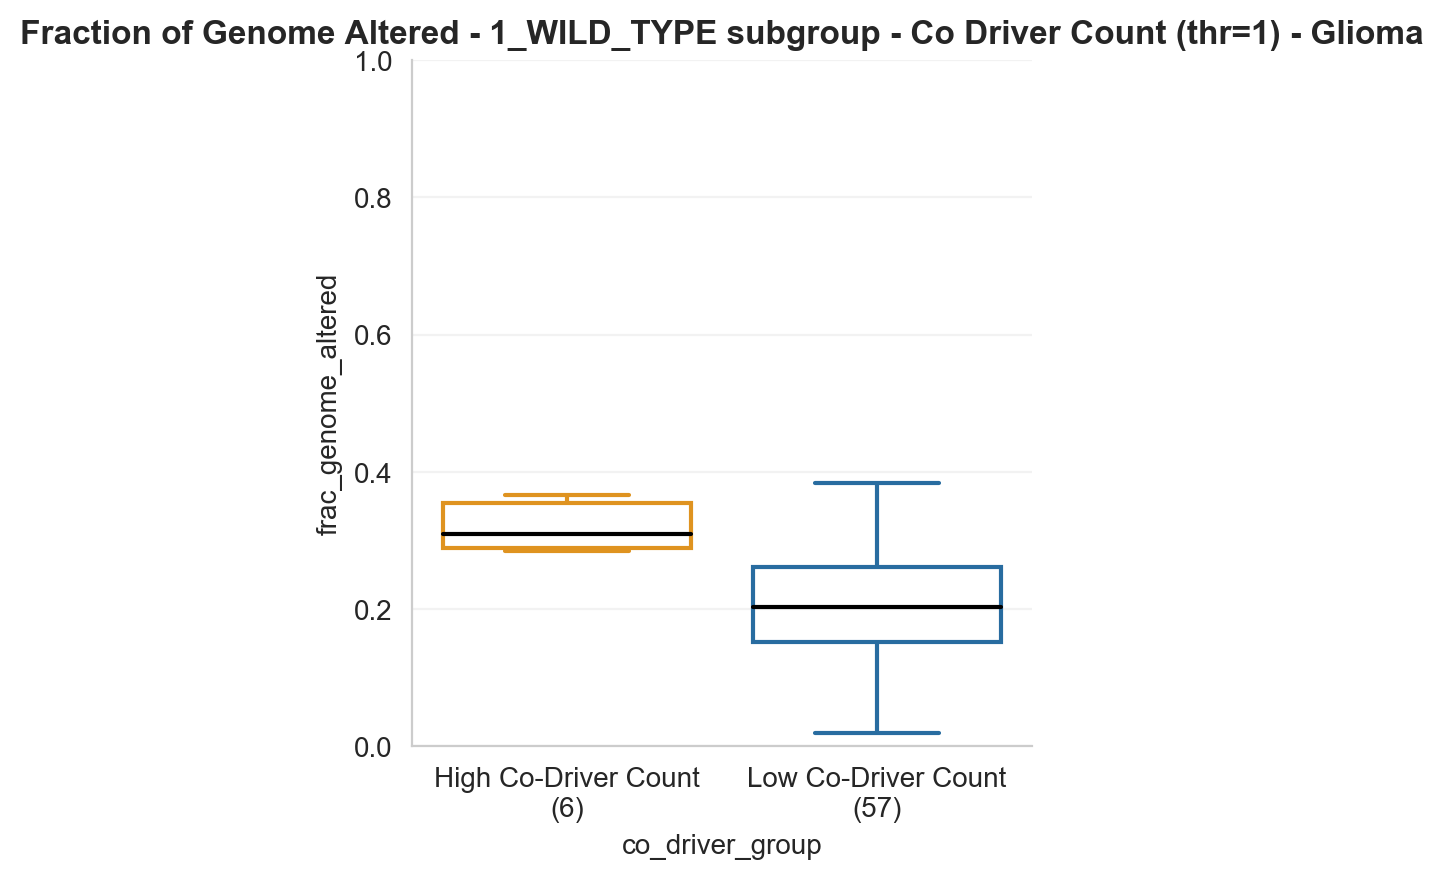

,0,1,2
0,,size,frac_genome_altered
1,High Co-Driver Count,6,0.3095
2,Low Co-Driver Count,57,0.203
3,,Statistics,p-value
4,,2.59903,0.00934888


In [29]:
fig, ax = boxplot_sampletype(df=master_no_wgd_cancer_wt,
                  group='co_driver_group',
                  palette={'High Co-Driver Count': '#FF9900' , 'Low Co-Driver Count': '#146EB4'},
                  order=['High Co-Driver Count', 'Low Co-Driver Count'],
                  metrics='frac_genome_altered',
                  figsize=(4,10),
                  title='Fraction of Genome Altered - 1_WILD_TYPE subgroup - Co Driver Count (thr={}) - {}'.format(thr,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_no_wgd_cancer_wt,
               group='co_driver_group',
               metrics='frac_genome_altered',
               group_list=['High Co-Driver Count', 'Low Co-Driver Count'])

#### 0_HETLOSS

In [30]:
master_no_wgd_cancer_het = master_no_wgd_cancer[master_no_wgd_cancer['tp53_group'] == '0_HETLOSS']

thr=1

def get_driver_groups(x):
    if x.indel_driver_mutation_count > thr:
        return 'High Co-Driver Count'
    if x.indel_driver_mutation_count <= thr:
        return 'Low Co-Driver Count'
    

master_no_wgd_cancer_het['co_driver_group'] = master_no_wgd_cancer_het.apply(get_driver_groups, axis=1)

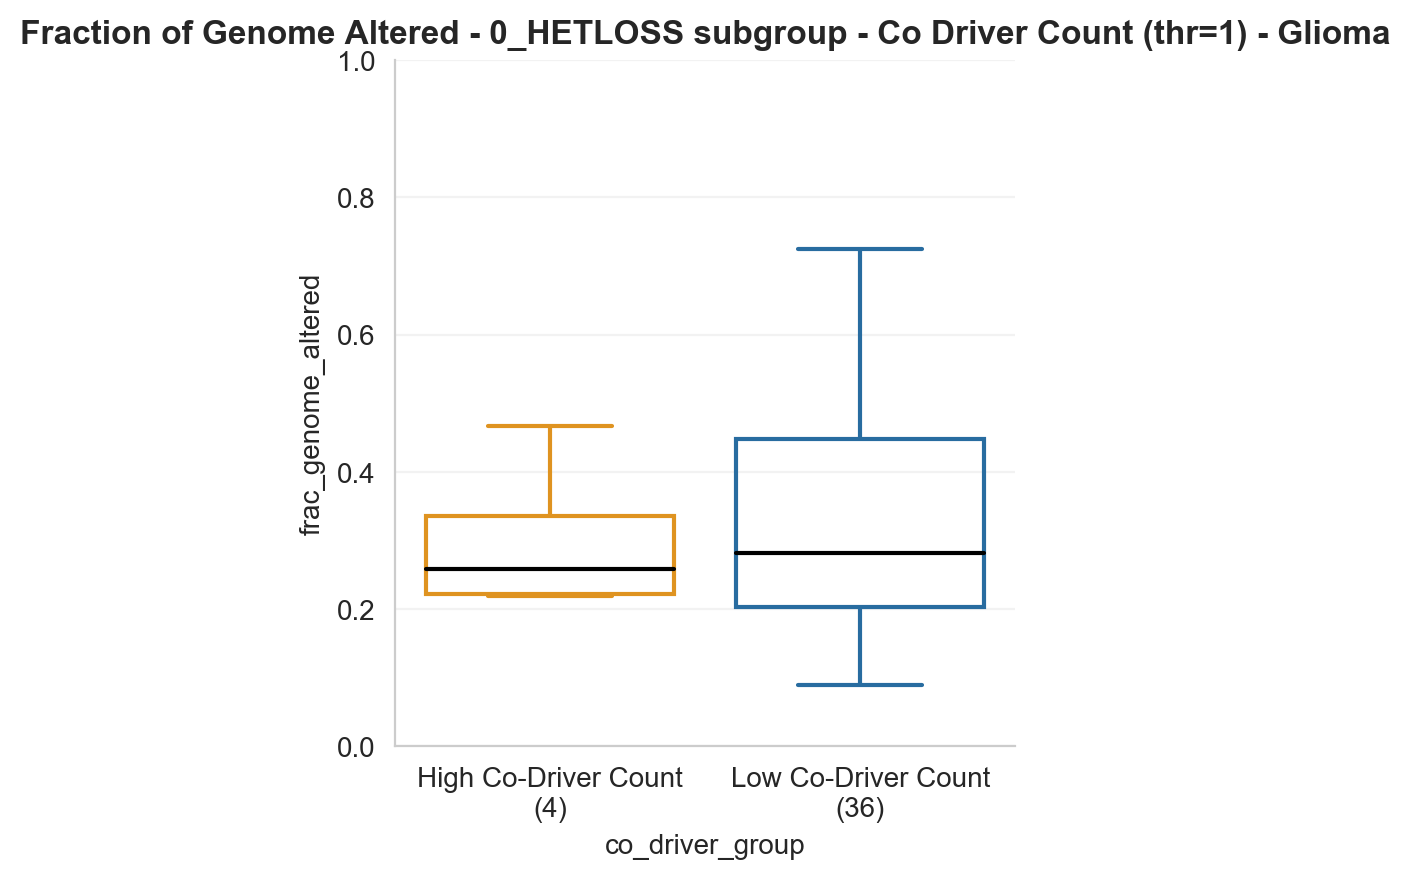

,0,1,2
0,,size,frac_genome_altered
1,High Co-Driver Count,4,0.258
2,Low Co-Driver Count,36,0.2815
3,,Statistics,p-value
4,,0.13525,0.892414


In [31]:
fig, ax = boxplot_sampletype(df=master_no_wgd_cancer_het,
                  group='co_driver_group',
                  palette={'High Co-Driver Count': '#FF9900' , 'Low Co-Driver Count': '#146EB4'},
                  order=['High Co-Driver Count', 'Low Co-Driver Count'],
                  metrics='frac_genome_altered',
                  figsize=(4,10),
                  title='Fraction of Genome Altered - 0_HETLOSS subgroup - Co Driver Count (thr={}) - {}'.format(thr,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_no_wgd_cancer_het,
               group='co_driver_group',
               metrics='frac_genome_altered',
               group_list=['High Co-Driver Count', 'Low Co-Driver Count'])

## CCF / VAF Analysis
Same here we take only samples with exactly 1 tp53 mutation (*master_hotspot*).

We have to define groups for CCF to see if there are differences between those groups. To have an idea of the CCF distribution we show here the distribution coming from the *cancer_panel*.

<img src='ccf.png' width=1000 length=1000>

We see that our tp53_ccf distribution is very high for all subgroups except for *1_WILD_TYPEAdd * and *>1muts*. *>=1_LOSS* is the biggest subgroup - by far - and has a very high CCF median.

It will be hard to cut the cohort based on the CCF. Let's try and see the size of the subcohorts:

In [58]:
master_ccf = master_no_wgd_cancer[(master_no_wgd_cancer['tp53_count'] == 1) | (master_no_wgd_cancer['tp53_group'] == '0_HETLOSS')]

In [59]:
thr_ccf_1 = 0.8 ; thr_ccf_2 = 0.9

def ccf_subgroup(x):
    if x.tp53_ccf_1 <= thr_ccf_1: return 'low'
    elif x.tp53_ccf_1 <= thr_ccf_2: return 'medium'
    elif x.tp53_ccf_1 > thr_ccf_2: return 'high'

master_ccf['ccf_group'] = master_ccf.apply(ccf_subgroup, axis=1)
get_groupby(master_ccf, 'ccf_group', 'count')

,count
ccf_group,
high,382
low,131
medium,78


In [60]:
thr_vaf_1 = 0.3 ; thr_vaf_2 = 0.4

def vaf_subgroup(x):
    if x.tp53_vaf_1 <= thr_vaf_1: return 'low'
    elif x.tp53_vaf_1 <= thr_vaf_2: return 'medium'
    elif x.tp53_vaf_1 > thr_vaf_2: return 'high'

master_ccf['vaf_group'] = master_ccf.apply(vaf_subgroup, axis=1)       
get_groupby(master_ccf, 'vaf_group', 'count')

,count
vaf_group,
high,101
low,432
medium,65


### VAF Analysis

#### No VAF Cut

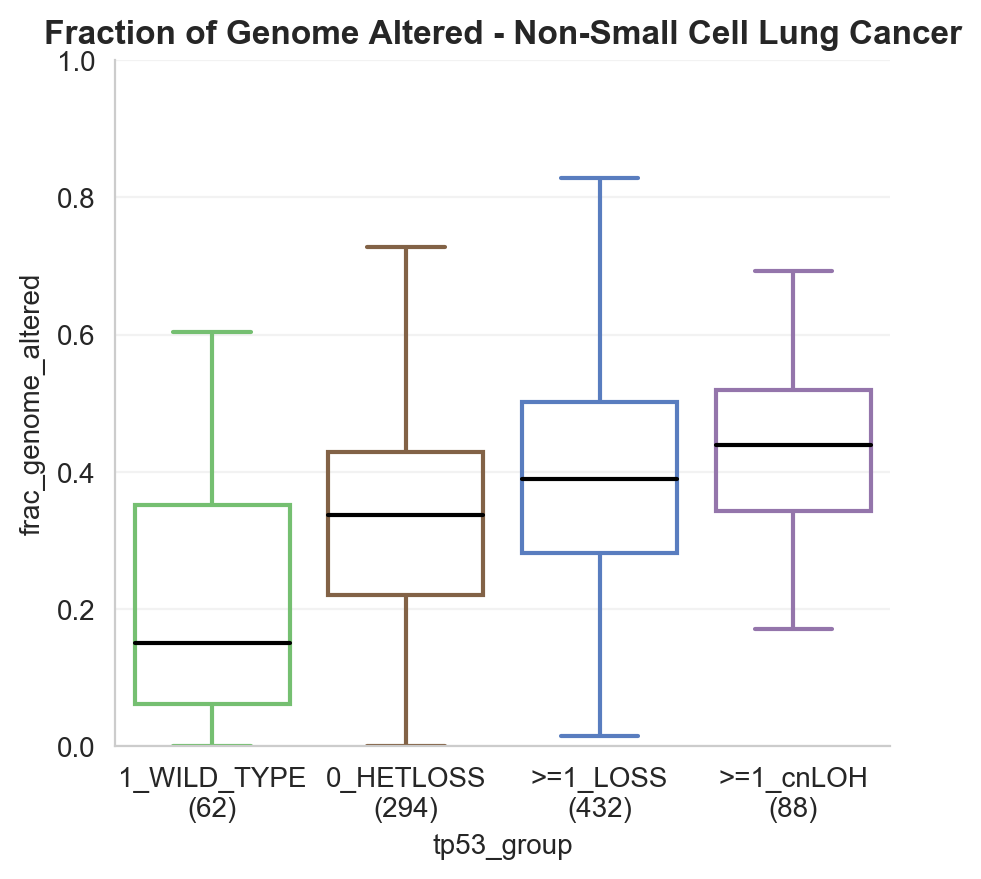

,0,1,2
0,,size,frac_genome_altered
1,0_HETLOSS,294,0.3375
2,1_WILD_TYPE,62,0.1505
3,,Statistics,p-value
4,,5.34833,8.87716e-08


In [61]:
fig, ax = boxplot_sampletype(df=master_ccf,
                  group='tp53_group',
                  palette=palette,
                  order=['1_WILD_TYPE','0_HETLOSS', '>=1_LOSS', '>=1_cnLOH'],
                  metrics='frac_genome_altered',
                  figsize=(5,10),
                  title='Fraction of Genome Altered - {}'.format(cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_ccf,
               group='tp53_group',
               metrics='frac_genome_altered',
               group_list=['0_HETLOSS', '1_WILD_TYPE'])

#### Low VAF

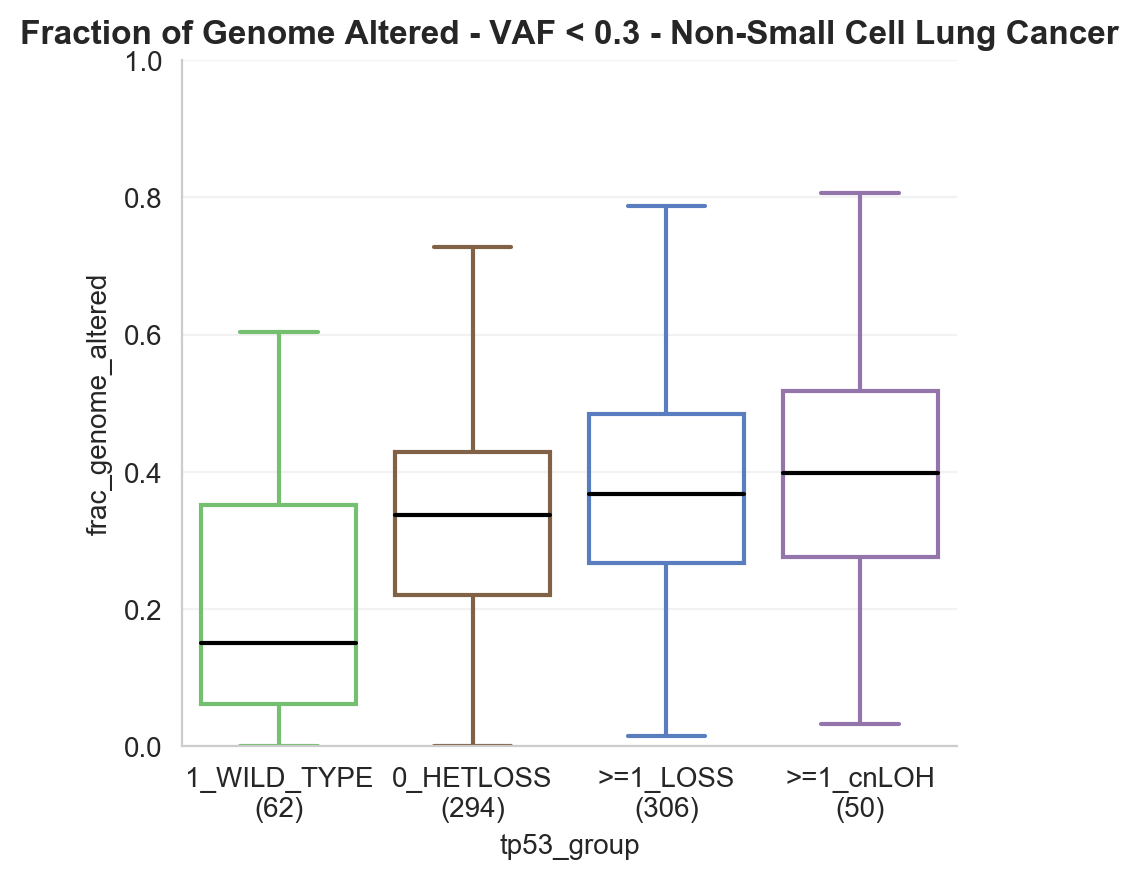

,0,1,2
0,,size,frac_genome_altered
1,1_WILD_TYPE,62,0.1505
2,>=1_LOSS,306,0.368
3,,Statistics,p-value
4,,-6.66275,2.68756e-11


In [62]:
master_low = master_ccf[(master_ccf['vaf_group'] == 'low') | (master_ccf['tp53_group'] == '0_HETLOSS')]

fig, ax = boxplot_sampletype(df=master_low,
                  group='tp53_group',
                  palette=palette,
                  order=['1_WILD_TYPE','0_HETLOSS', '>=1_LOSS', '>=1_cnLOH'],
                  metrics='frac_genome_altered',
                  figsize=(5,10),
                  title='Fraction of Genome Altered - VAF < {} - {}'.format(thr_vaf_1,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_low,
               group='tp53_group',
               metrics='frac_genome_altered',
               group_list=['1_WILD_TYPE', '>=1_LOSS'])

#### Medium VAF

KeyError: '1_WILD_TYPE'

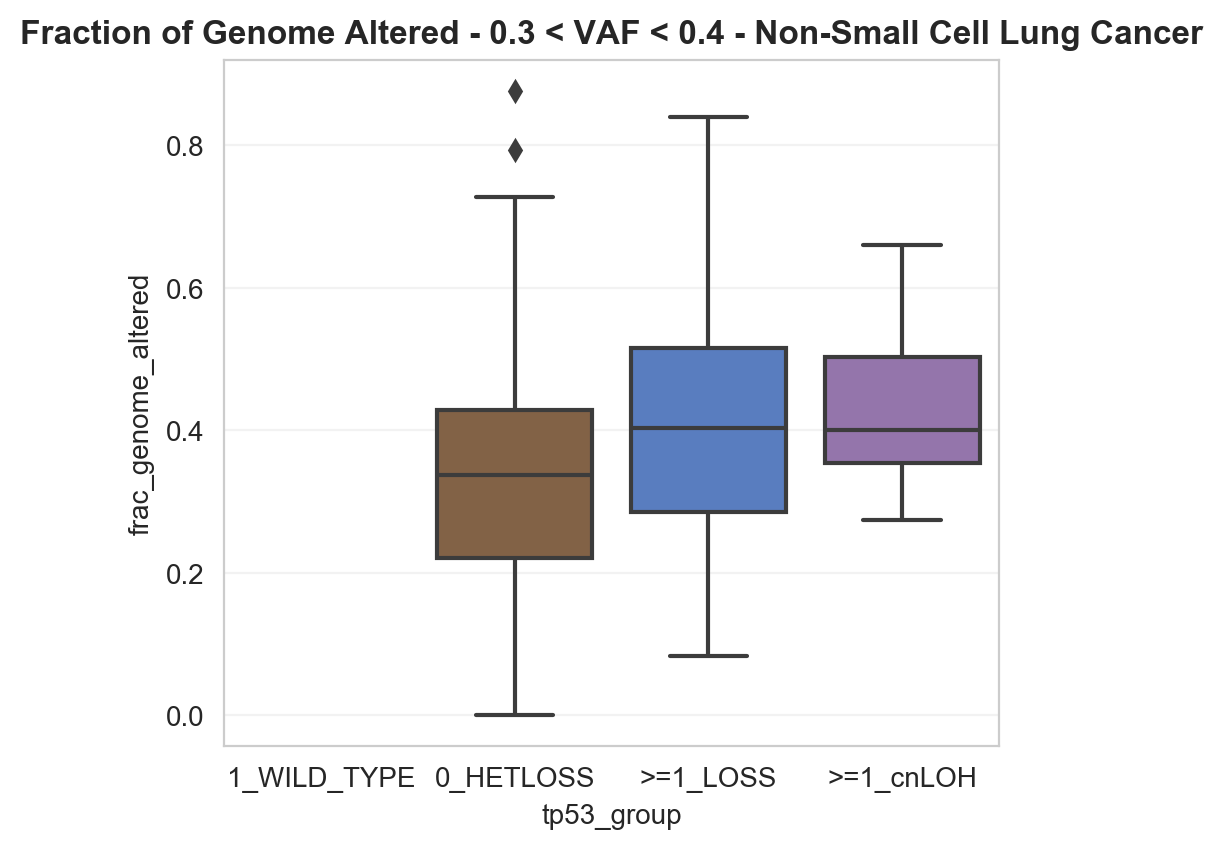

In [63]:
master_med = master_ccf[(master_ccf['vaf_group'] == 'medium') | (master_ccf['tp53_group'] == '0_HETLOSS')]

fig, ax = boxplot_sampletype(df=master_med,
                  group='tp53_group',
                  palette=palette,
                  order=['1_WILD_TYPE', '0_HETLOSS', '>=1_LOSS', '>=1_cnLOH'],
                  metrics='frac_genome_altered',
                  figsize=(5,10),
                  title='Fraction of Genome Altered - {} < VAF < {} - {}'.format(thr_vaf_1,thr_vaf_2,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_med,
               group='tp53_group',
               metrics='frac_genome_altered',
               group_list=['1_WILD_TYPE', '0_HETLOSS'])

#### High VAF

KeyError: '1_WILD_TYPE'

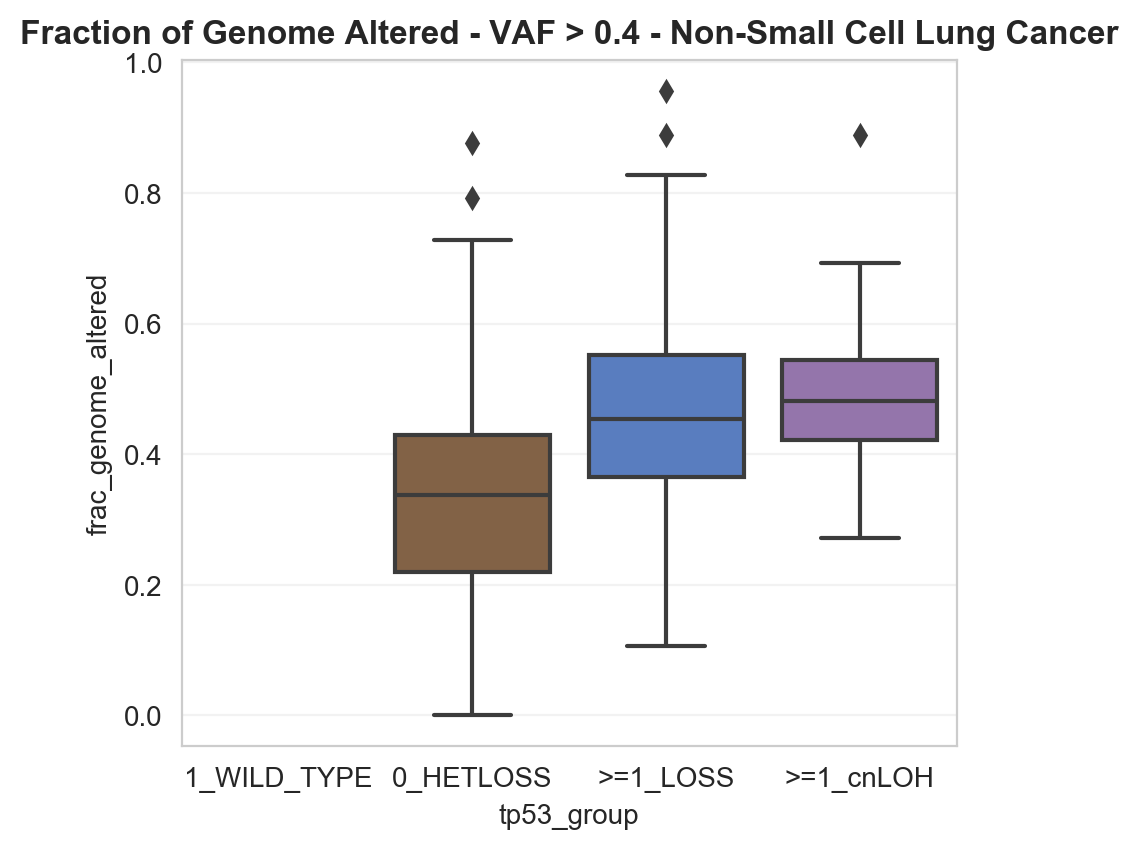

In [64]:
master_high = master_ccf[(master_ccf['vaf_group'] == 'high') | (master_ccf['tp53_group'] == '0_HETLOSS')]

fig, ax = boxplot_sampletype(df=master_high,
                  group='tp53_group',
                  palette=palette,
                  order=['1_WILD_TYPE', '0_HETLOSS', '>=1_LOSS', '>=1_cnLOH'],
                  metrics='frac_genome_altered',
                  figsize=(5,10),
                  title='Fraction of Genome Altered - VAF > {} - {}'.format(thr_vaf_2,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_high,
               group='tp53_group',
               metrics='frac_genome_altered',
               group_list=['1_WILD_TYPE', '0_HETLOSS'])

### CCF Analysis

#### No CCF Cut

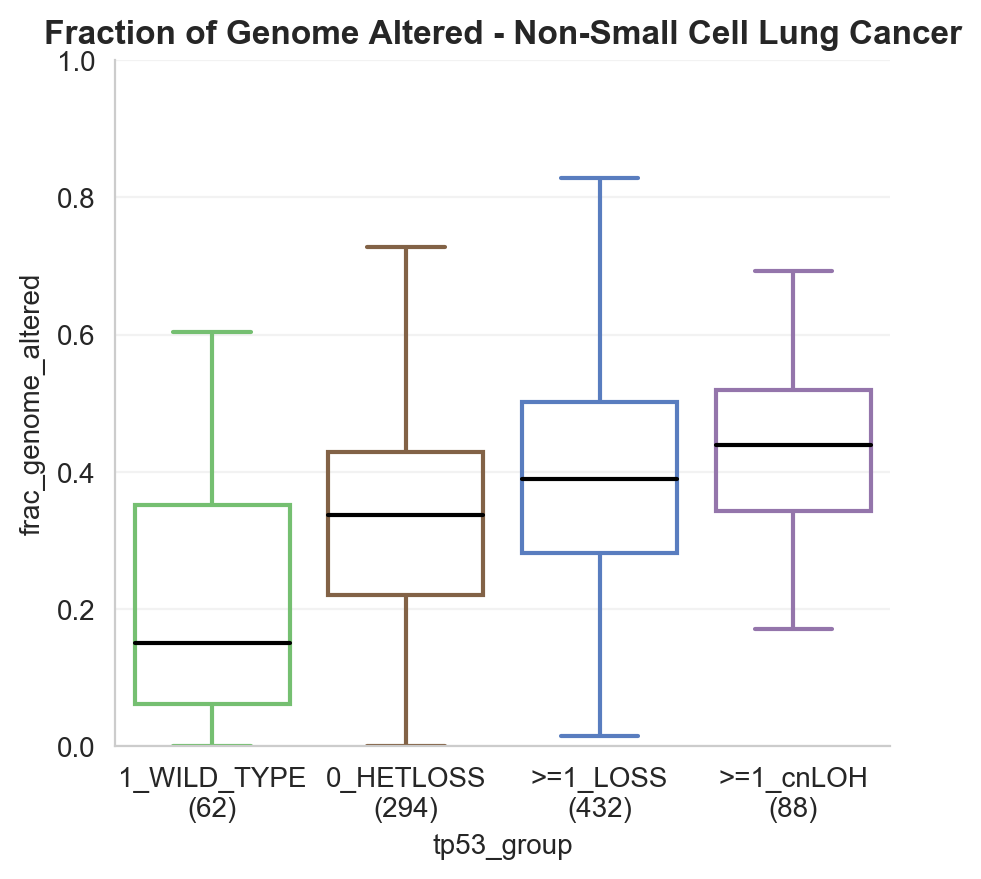

,0,1,2
0,,size,frac_genome_altered
1,0_HETLOSS,294,0.3375
2,1_WILD_TYPE,62,0.1505
3,,Statistics,p-value
4,,5.34833,8.87716e-08


In [65]:
fig, ax = boxplot_sampletype(df=master_ccf,
                  group='tp53_group',
                  palette=palette,
                  order=['1_WILD_TYPE','0_HETLOSS', '>=1_LOSS', '>=1_cnLOH'],
                  metrics='frac_genome_altered',
                  figsize=(5,10),
                  title='Fraction of Genome Altered - {}'.format(cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_ccf,
               group='tp53_group',
               metrics='frac_genome_altered',
               group_list=['0_HETLOSS', '1_WILD_TYPE'])

#### Low CCF

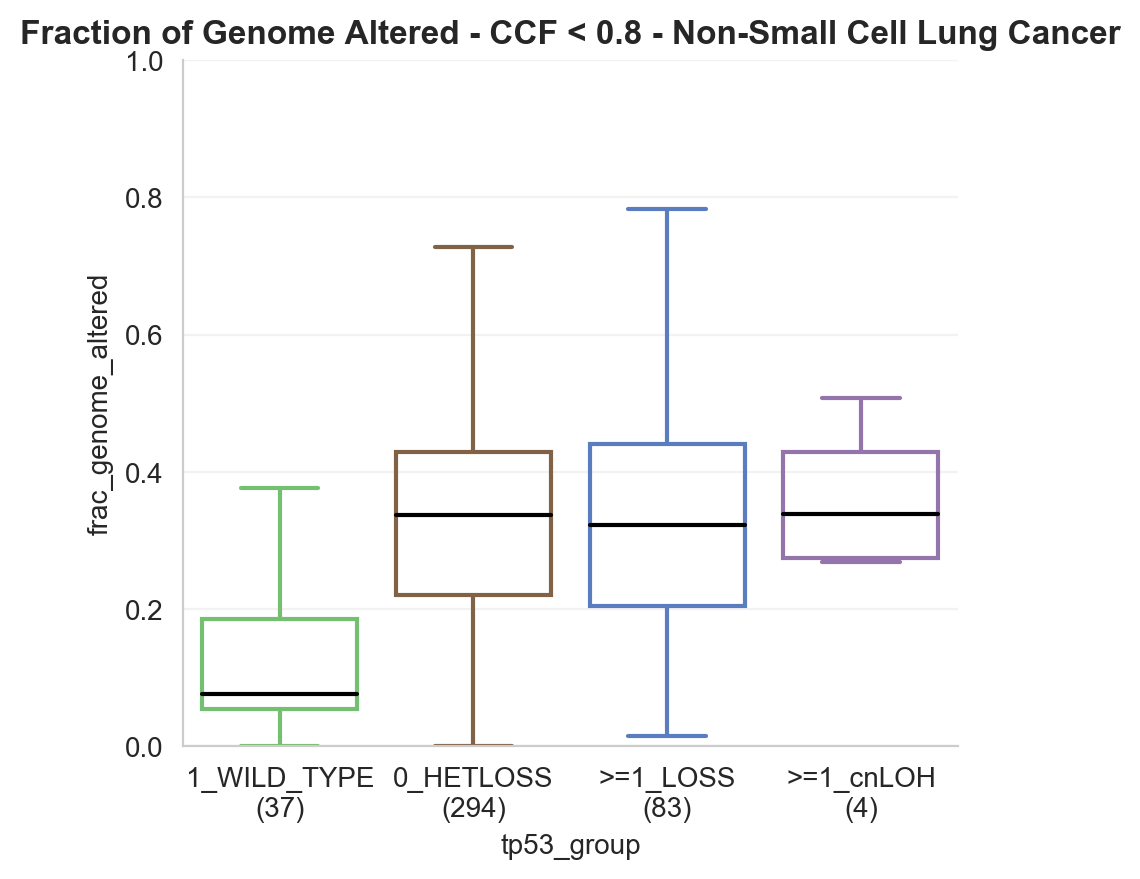

,0,1,2
0,,size,frac_genome_altered
1,1_WILD_TYPE,37,0.076
2,0_HETLOSS,294,0.3375
3,,Statistics,p-value
4,,-7.31139,2.64401e-13


In [66]:
master_low = master_ccf[(master_ccf['ccf_group'] == 'low') | (master_ccf['tp53_group'] == '0_HETLOSS')]

fig, ax = boxplot_sampletype(df=master_low,
                  group='tp53_group',
                  palette=palette,
                  order=['1_WILD_TYPE','0_HETLOSS', '>=1_LOSS', '>=1_cnLOH'],
                  metrics='frac_genome_altered',
                  figsize=(5,10),
                  title='Fraction of Genome Altered - CCF < {} - {}'.format(thr_ccf_1,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_low,
               group='tp53_group',
               metrics='frac_genome_altered',
               group_list=['1_WILD_TYPE', '0_HETLOSS'])

#### Medium CCF

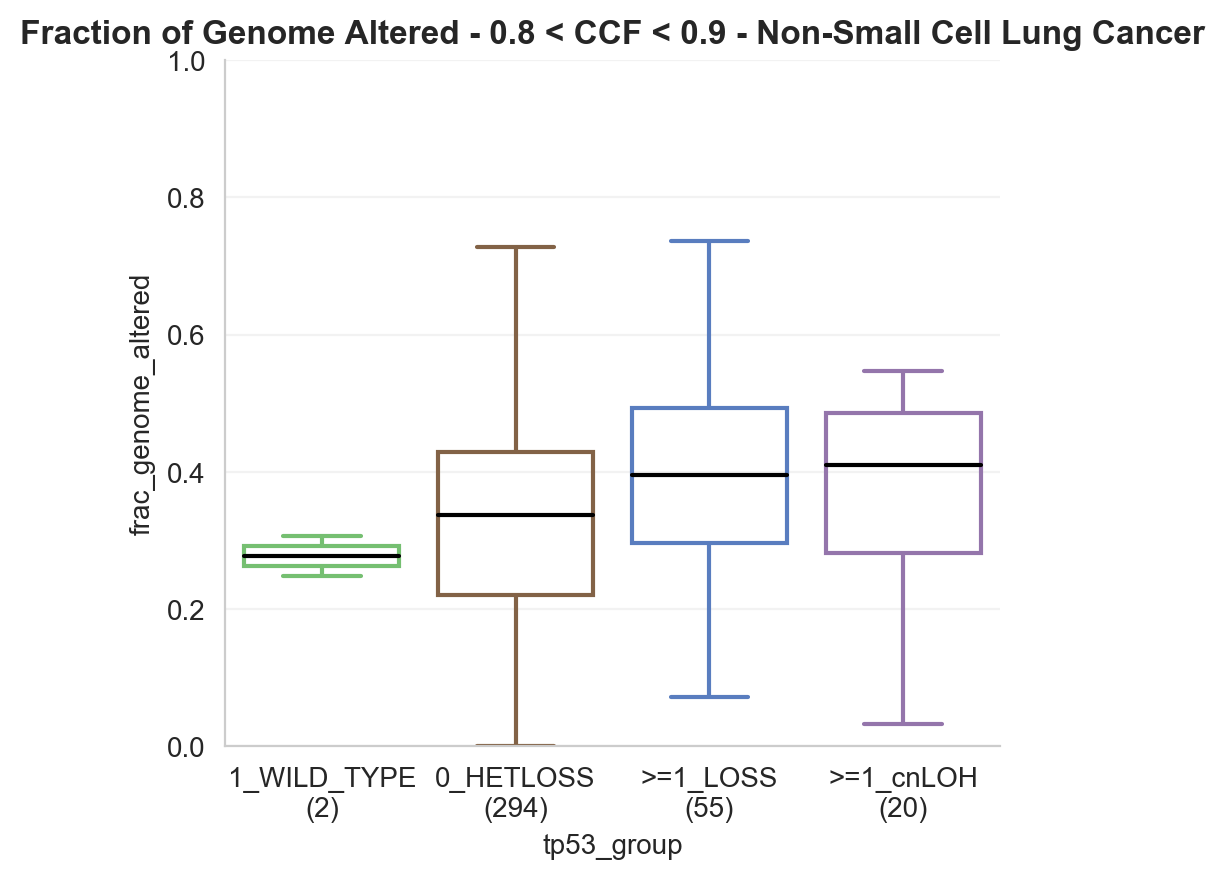

,0,1,2
0,,size,frac_genome_altered
1,1_WILD_TYPE,2,0.2775
2,0_HETLOSS,294,0.3375
3,,Statistics,p-value
4,,-0.663153,0.507233


In [67]:
master_med = master_ccf[(master_ccf['ccf_group'] == 'medium') | (master_ccf['tp53_group'] == '0_HETLOSS')]

fig, ax = boxplot_sampletype(df=master_med,
                  group='tp53_group',
                  palette=palette,
                  order=['1_WILD_TYPE', '0_HETLOSS', '>=1_LOSS', '>=1_cnLOH'],
                  metrics='frac_genome_altered',
                  figsize=(5,10),
                  title='Fraction of Genome Altered - {} < CCF < {} - {}'.format(thr_ccf_1,thr_ccf_2,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_med,
               group='tp53_group',
               metrics='frac_genome_altered',
               group_list=['1_WILD_TYPE', '0_HETLOSS'])

#### High CCF

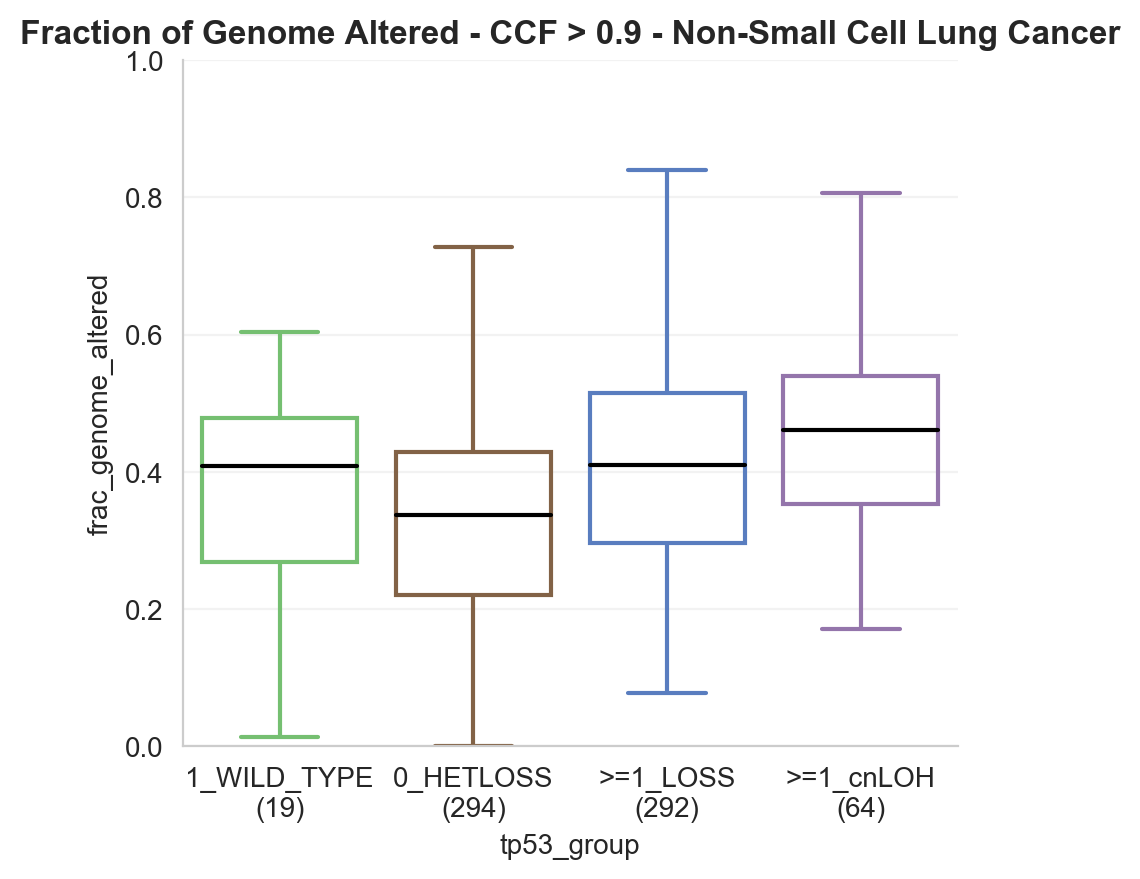

,0,1,2
0,,size,frac_genome_altered
1,1_WILD_TYPE,19,0.408
2,0_HETLOSS,294,0.3375
3,,Statistics,p-value
4,,1.12079,0.262375


In [68]:
master_high = master_ccf[(master_ccf['ccf_group'] == 'high') | (master_ccf['tp53_group'] == '0_HETLOSS')]

fig, ax = boxplot_sampletype(df=master_high,
                  group='tp53_group',
                  palette=palette,
                  order=['1_WILD_TYPE', '0_HETLOSS', '>=1_LOSS', '>=1_cnLOH'],
                  metrics='frac_genome_altered',
                  figsize=(5,10),
                  title='Fraction of Genome Altered - CCF > {} - {}'.format(thr_ccf_2,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_high,
               group='tp53_group',
               metrics='frac_genome_altered',
               group_list=['1_WILD_TYPE', '0_HETLOSS'])

### Splitting on the different level of CCF / VAF

In [ ]:
fig, ax = boxplot_sampletype(df=master_hotspot,
                  group='vaf_group',
                  palette={'low': tab10[0] , 'medium': tab10[1], 'high':tab10[2]},
                  order=['low', 'medium', 'high'],
                  metrics='frac_genome_altered',
                  figsize=(3,10),
                  title='Fraction of Genome Altered - VAF levels - {}'.format(cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_hotspot,
               group='vaf_group',
               metrics='frac_genome_altered',
               group_list=['low', 'medium'])

In [ ]:
fig, ax = boxplot_sampletype(df=master_hotspot,
                  group='ccf_group',
                  palette={'low': tab10[0] , 'medium': tab10[1], 'high':tab10[2]},
                  order=['low', 'medium', 'high'],
                  metrics='frac_genome_altered',
                  figsize=(3,10),
                  title='Fraction of Genome Altered - CCF levels - {}'.format(cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_hotspot,
               group='ccf_group',
               metrics='frac_genome_altered',
               group_list=['low', 'medium'])

## Clinical Correlates

### Age

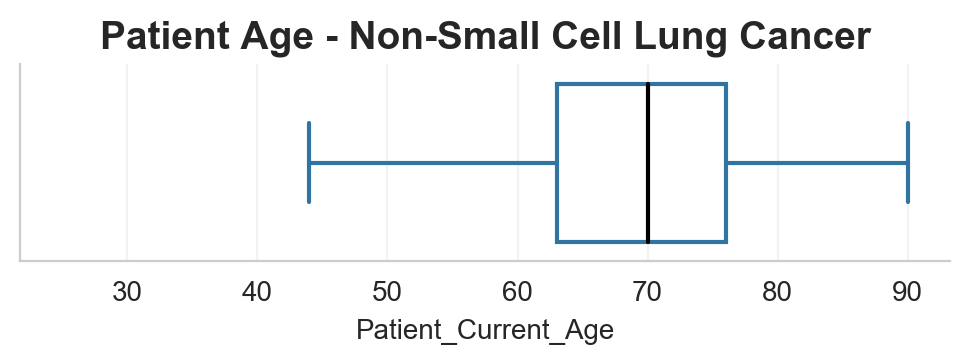

In [15]:
#### TP53 Residual Groups#fig=plt.figure(figsize=(10,3))
ax = plt.subplot2grid(shape=(4,1), loc=(0,0), colspan=1)

sns.boxplot(x='Patient_Current_Age',data=master_no_wgd_cancer, ax=ax).set_title('Patient Age - {}'.format(cancer), weight='bold', fontsize=14)


style(ax)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#### TP53 Residual Groups

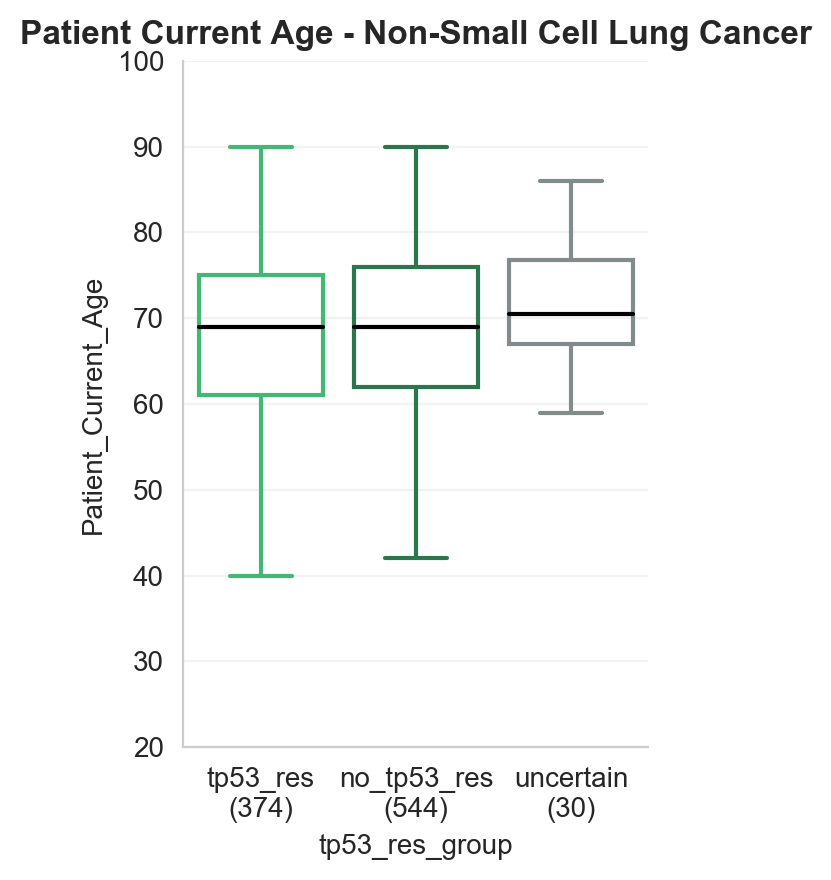

,0,1,2
0,,size,Patient_Current_Age
1,tp53_res,374,69
2,no_tp53_res,544,69
3,,Statistics,p-value
4,,-0.25777,0.796585


In [16]:
fig, ax = boxplot_sampletype(df=master_no_wgd_cancer,
                  group='tp53_res_group',
                  palette=palette_res,
                  order=res_group_list,
                  metrics='Patient_Current_Age',
                  figsize=(3,10),
                  title='Patient Current Age - {}'.format(cancer),
                  xlim=[20,100])
plt.show()

get_statistics(df=master_no_wgd_cancer,
               group='tp53_res_group',
               metrics='Patient_Current_Age',
               group_list=['tp53_res', 'no_tp53_res'])#### TP53 Subgroups

#### TP53 Subgroups

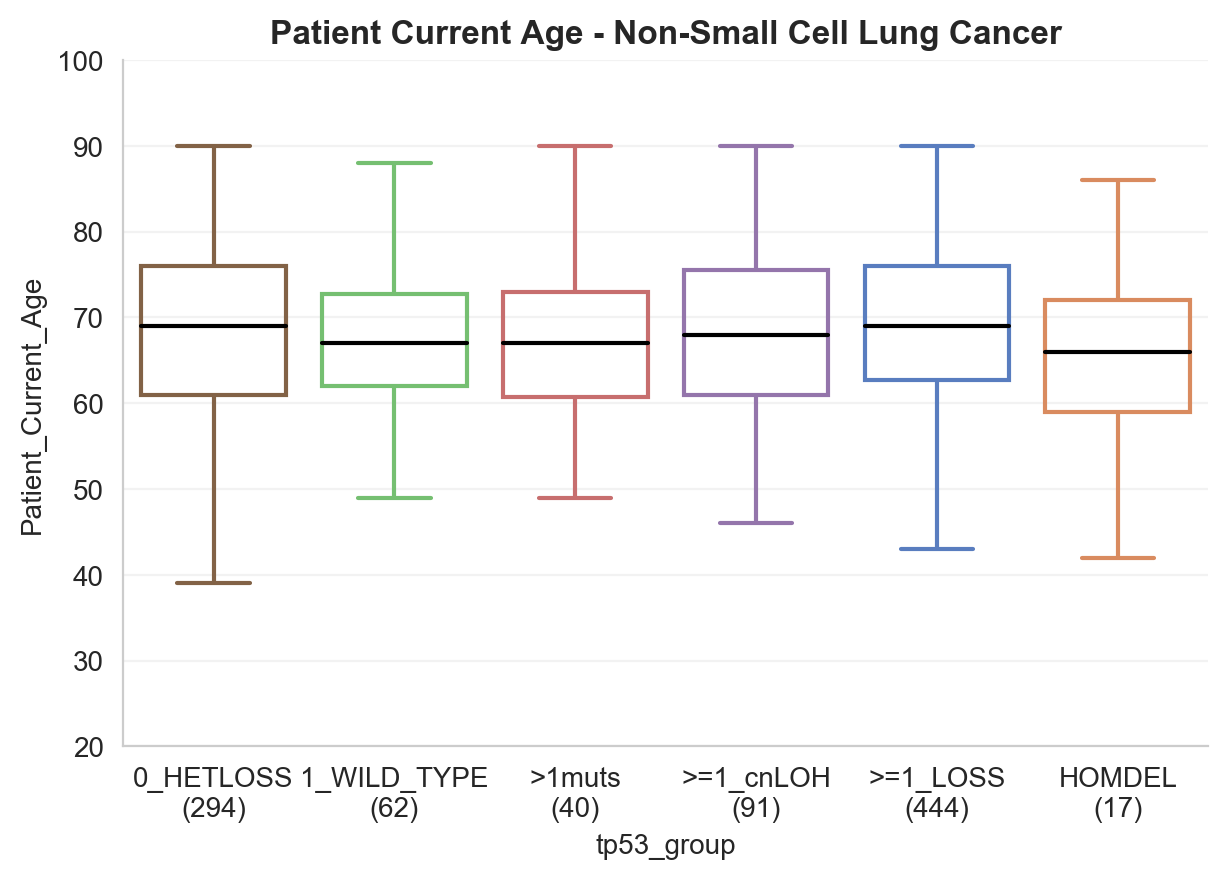

,0,1,2
0,,size,Patient_Current_Age
1,1_WILD_TYPE,62,67
2,>=1_cnLOH,91,68
3,,Statistics,p-value
4,,-0.533293,0.593831


In [17]:
fig, ax = boxplot_sampletype(df=master_no_wgd_cancer,
                  group='tp53_group',
                  palette=palette,
                  order=group_list,
                  metrics='Patient_Current_Age',
                  figsize=(7,10),
                  title='Patient Current Age - {}'.format(cancer),
                  xlim=[20,100])
plt.show()

get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='Patient_Current_Age',
               group_list=['1_WILD_TYPE', '>=1_cnLOH'])

### Sex

,count
Sex,
Female,1042
Male,733


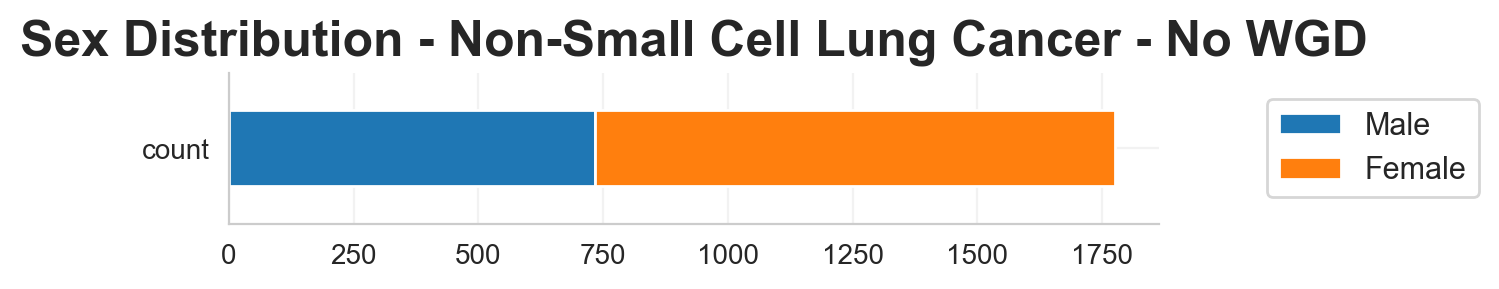

In [18]:
h = get_groupby(master_no_wgd_cancer,'Sex', 'count').sort_values(by='count', ascending=False)
display(h)

h = h.T
h = h[['Male', 'Female']]
fig = plt.figure(figsize=(6,1))
ax = plt.subplot()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

h_plot = h.plot(kind = 'barh', stacked=True, yticks=[], ax=ax)
ax.legend(['Male', 'Female'],loc='center left', bbox_to_anchor=(1.1, 0.5), fontsize=11)
ax.set_title('Sex Distribution - {} - No WGD'.format(cancer), weight='bold', fontsize=18)

plt.show()

### Survival Analysis

In [20]:
from lifelines import KaplanMeierFitter

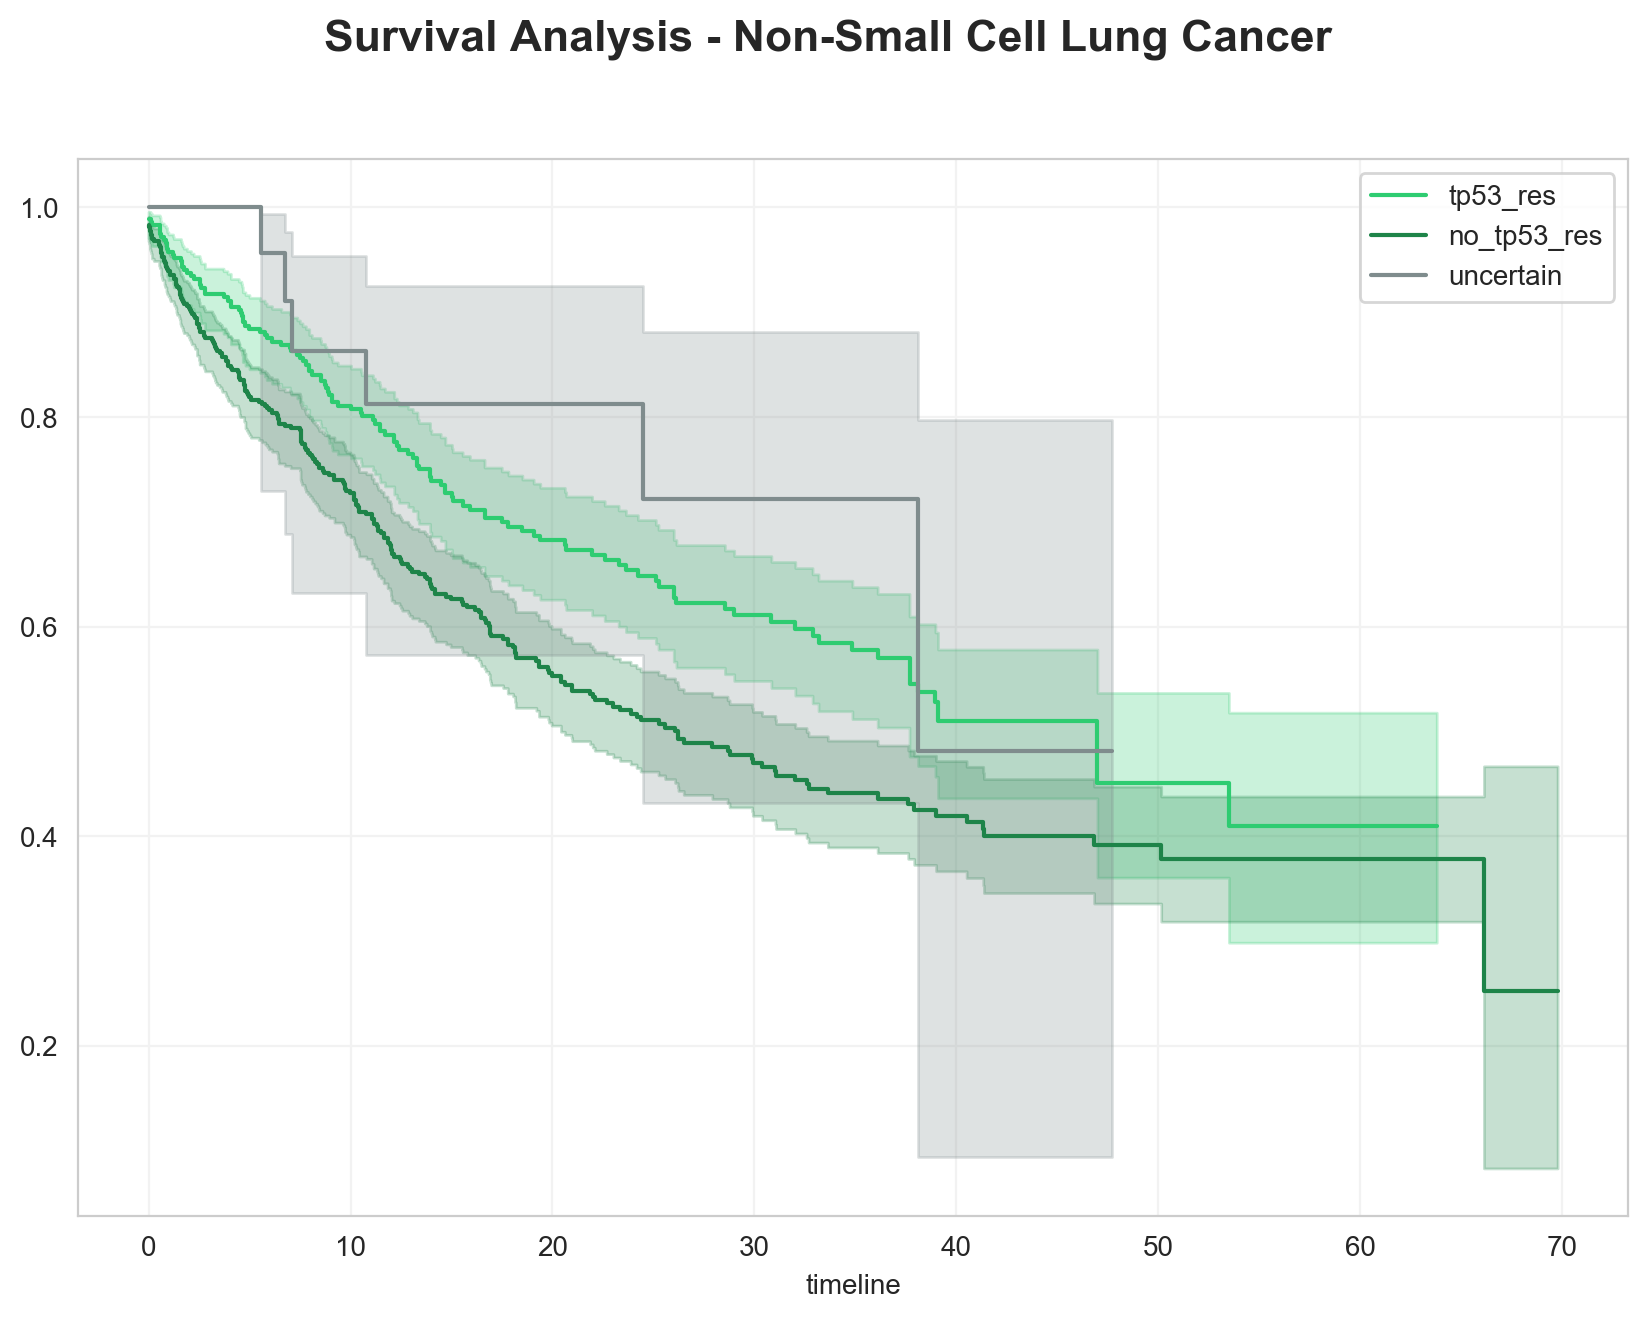

In [23]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
fig.suptitle('Survival Analysis - {}'.format(cancer), fontsize=16, weight='bold')
kmf = KaplanMeierFitter()

for group,i in zip(res_group_list, range(len(res_group_list))):
    data = master_no_wgd_cancer[master_no_wgd_cancer['tp53_res_group'] == group].dropna(subset=['Overall_Survival_Months', 'Overall_Survival_Status'])
    data['Overall Survival Status 0/1'] = data.apply(lambda x: 1 if x['Overall_Survival_Status'] == 'DECEASED' else 0, axis=1)
    kmf.fit(np.array(data['Overall_Survival_Months']), event_observed=np.array(data['Overall Survival Status 0/1']),  label= group)
    kmf.plot_survival_function(color = res_palette_list[i], ax=ax)
plt.show()

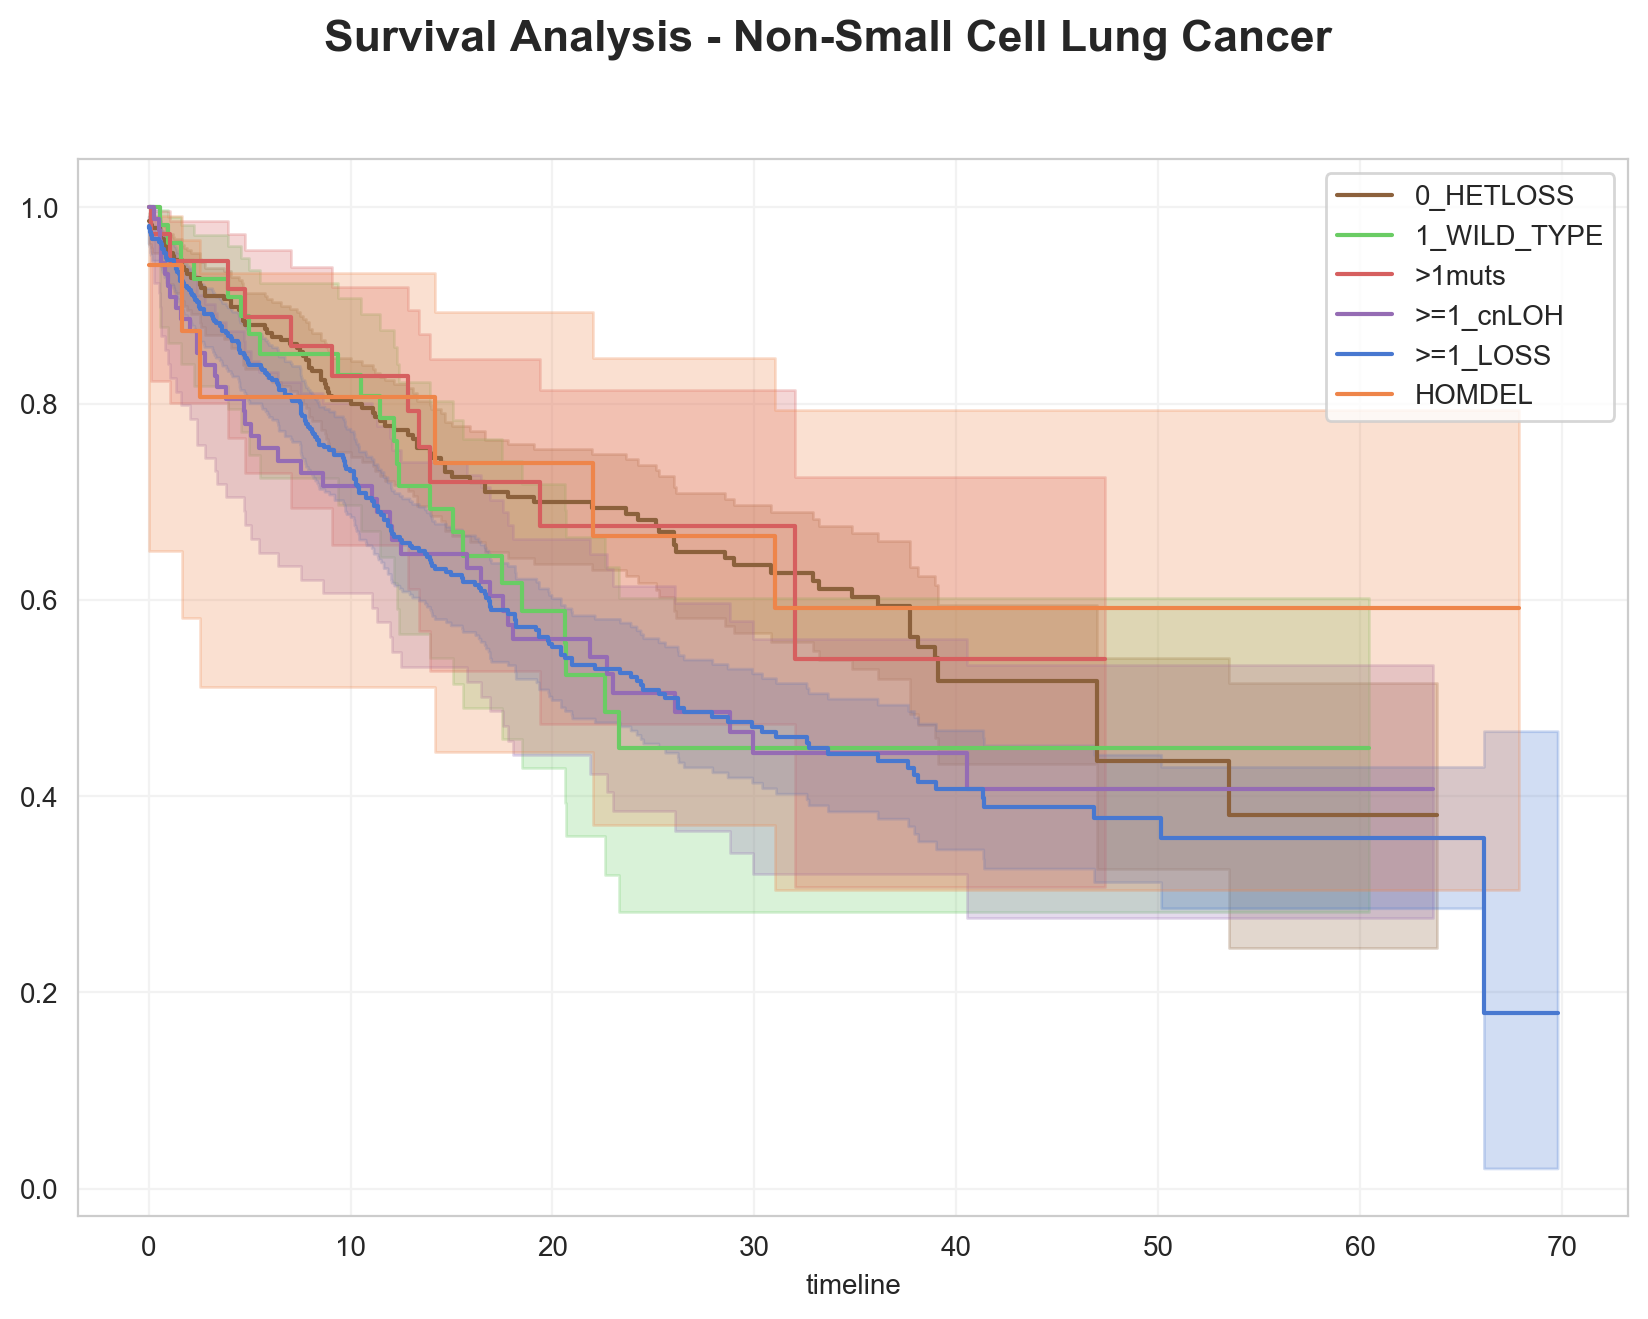

In [24]:

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
fig.suptitle('Survival Analysis - {}'.format(cancer), fontsize=16, weight='bold')
kmf = KaplanMeierFitter()

for group,i in zip(group_list, range(len(group_list))):
    data = master_no_wgd_cancer[master_no_wgd_cancer['tp53_group'] == group].dropna(subset=['Overall_Survival_Months', 'Overall_Survival_Status'])
    data['Overall Survival Status 0/1'] = data.apply(lambda x: 1 if x['Overall_Survival_Status'] == 'DECEASED' else 0, axis=1)
    kmf.fit(np.array(data['Overall_Survival_Months']), event_observed=np.array(data['Overall Survival Status 0/1']),  label= group)
    kmf.plot_survival_function(color = palette_list[i], ax=ax)
plt.show()